In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import pandas as pd
import pickle
import ccf_analysis_utils
import functions as func
import os

In [2]:
epochs = ['sample', 'delay', 'response']
method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}
areas = ['Medulla','Midbrain','ALM', 'Striatum', 'Thalamus',]
df = pd.read_excel('mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx',engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

r2_new = pickle.load(open('r2_data_dict_smallwindows_v3.pkl', 'rb'))

ccf_labels = r2_new['5_0']['ccf_labels'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
# center around bregma
ccf_coords[:,0] -= 5700
ccf_coords[:,2] -= 5400

is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]

In [3]:
figfolder = 'figs/plots_for_nuo/'
os.makedirs(figfolder, exist_ok= True)

#timeshifts = [-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16]
#timeshifts = np.array(timeshifts)
timeshifts = np.arange(-30,32,2, dtype = int)

In [4]:
thalamus_use_nuclei = [
    'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    'Paraventricular nucleus of the thalamus', #PVN
    'Reticular nucleus of the thalamus', #RT
    'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posteromedial nucleus of the thalamus', #VPN
]

short_names = [
    'AN',
    'CN',
    'MD',
    'MGN',
    'PC',
    'PF',
    'PO',
    'PVN',
    'RT',
    'SMN',
    'VAL',
    'VM',
    'VPN',
]

short_names_correct_allen = [
    'AM',
    'CM',
    'MD',
    'MG',
    'PCN',
    'PF',
    'PO',
    'PVT',
    'RT',
    'SMT',
    'VAL',
    'VM',
    'VPM',    
]

In [4]:
def get_single_area_inds(area, df, ccf_labels):
    subregion_labels = func.get_all_subregion_annotations_from_name(df, area)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, {area: subregion_labels})
    return inds[area]

get_single_area_inds('Mediodorsal nucleus of thalamus', df, ccf_labels).shape

(1646,)

In [5]:
def get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds):
    subregions_annotation_dict = dict()
    for subreg in region_list:
        if subreg == 'ALM':
            continue
        else:
            subregions_annotation_dict[subreg] = func.get_all_subregion_annotations_from_name(df, subreg)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, subregions_annotation_dict)

    if 'ALM' in region_list:
        use_inds = dict()
        use_inds['ALM'] = alm_inds
        for k,v in inds.items():
            use_inds[k] = np.setdiff1d(v, alm_inds)
        
        return use_inds
    
    return inds

def create_one_epoch_barplots(ax, r2_new, inds, subregions_list, axis_names, cc,ylabel, quantity, r2_method = 'new', epoch = 'response', method_to_string = {'old':'_old', 'old_clipped':'_old', 'new':''}):
    n_neurons = [v.shape[0] for v in inds.values()]
    
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    if quantity == 'r2':
        m, sem = func.get_mean_and_sem_for_subregions(r2, inds, subregions_list)
    elif quantity == 'fr':
        m, sem = func.get_mean_and_sem_for_subregions(fr, inds, subregions_list)
    plt.bar(np.arange(0,len(m)), 
                m, yerr = sem, alpha = 0.8, color = cc, 
                capsize = 3, width=0.5, label = epoch)
    for i in range(len(n_neurons)):
        ax.text(i-0.1, m[i] + sem[i] + 0.1 * max(sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.legend()
    _ = ax.set_xticks(np.arange(0,len(m)))
    _ = ax.set_xticklabels(axis_names, rotation = 0)
    _ = ax.set_ylabel(ylabel)

def create_timeshift_curves_plot_single_epoch(ax, r2_new, timeshifts, inds, axis_names, cc, r2_method, epoch, method_to_string = {'old':'_old', 'old_clipped':'_old', 'new':''} ):
    r2 = []

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch, method_to_string[r2_method])].copy())

    r2= np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    ax.set_title('normalized timeshift curve, %s'%(epoch), fontsize = 16)
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]
        avg_r2 = r2[:,this_inds].mean(axis = 1)

        ax.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],color = cc[j], ls= 'solid', label = area + ', ' + epoch)

    a,b = ax.set_xlim()
    ax.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    ax.set_xlim(a,b)

    a,b = ax.set_ylim()
    ax.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    ax.set_ylim(a,b)

    ax.set_xlabel('Time shift (ms)', fontsize = 16)
    ax.set_ylabel('Normalized R2', fontsize = 16)

def create_timeshift_barplot_single_epoch(ax, r2_new, timeshifts, inds, axis_names, cc, r2_method, epoch, method_to_string = {'old':'_old', 'old_clipped':'_old', 'new':''}):
    r2 = []

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch, method_to_string[r2_method])].copy())

    r2= np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    ax.set_title('Mean best timeshifts, %s'%(epoch), fontsize = 16)
    means = []
    sems = []
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]

        this_area_r2 = r2[:,this_inds]
        best_timeshift = np.argmax(this_area_r2, axis = 0)

        timeshift_array = 3.4 * timeshifts[best_timeshift]

        avg_timeshift = np.mean(timeshift_array)
        std_timeshift = np.std(timeshift_array)
        sem_timeshift = std_timeshift/np.sqrt(len(timeshift_array))
        means.append(avg_timeshift)
        sems.append(sem_timeshift)


    ax.bar(np.arange(len(means)), means, yerr = sems, color = cc, capsize = 3)
    _= ax.set_xticks(np.arange(len(means)))
    _ = ax.set_xticklabels(axis_names, rotation = 0)
    ax.set_ylabel('Mean best time shift (ms)', fontsize = 16)  


def create_timeshift_violin_plot_single_epoch(ax, r2_new, timeshifts, inds, axis_names, cc, r2_method, epoch, fr_threshold=5, r2_threshold=0.02, method_to_string={'old':'_old', 'old_clipped':'_old', 'new':''}):
    r2 = []
    fr = r2_new['5_0']['avg_fr'].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

    r2 = np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2 < 0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)

    ax.set_title('%s' % (epoch), fontsize=16)

    data_to_plot = []
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]
        this_inds = np.intersect1d(this_inds, threshold_inds)
        this_area_r2 = r2[:, this_inds]
        best_timeshift = np.argmax(this_area_r2, axis=0)
        timeshift_array = 3.4 * timeshifts[best_timeshift]  # Assuming this is correct based on your code
        if len(timeshift_array) > 0:
            data_to_plot.append(timeshift_array)
        else:
            data_to_plot.append(np.array([0]))  # Append a zero array if no data

    # Creating violin plots
    parts = ax.violinplot(data_to_plot, points = 1000, showmeans=True, showmedians=False, bw_method=0.3)

    # Coloring each violin plot
    for ipc, pc in enumerate(parts['bodies']):
        pc.set_facecolor(cc[ipc])
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)

    ax.set_xticks(np.arange(1, len(axis_names) + 1))
    ax.set_xticklabels(axis_names, rotation=0)
    ax.set_ylabel('Distribution of best time shift (ms)', fontsize=16)



def create_summary_plot(region_list, color_list, r2_new, timeshifts, epochs, r2_method, axis_names, titlestr,alm_inds, epoch = 'response', method_to_string={'old':'_old', 'old_clipped':'_old', 'new':''}, fr_threshold = 5, r2_threshold = 0.02, delta_r2 = 1.2,  n_min = 0):
    inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
    r2 = []
    fr = r2_new['5_0']['avg_fr'].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

    r2 = np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2 < 0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    #delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)
    #threshold_inds = np.intersect1d(threshold_inds, delta_inds)

    _inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
    use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

    use_regions = list(use_inds.keys())

    use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]
    f = plt.figure(figsize=(20,20))
    f.suptitle(titlestr + '%s, fr_min = %.2f, r2_min = %.3f, delta_r2 =%.2f'%(epoch,fr_threshold,r2_threshold,delta_r2), fontsize=20)

    ax_bar = f.add_subplot(2,2,1)
    create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean R2', 'r2', r2_method, epoch,)

    ax_bar = f.add_subplot(2,2,2)
    create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean FR', 'fr', r2_method, epoch,)

    ax_bar = f.add_subplot(2,2,3)
    create_timeshift_curves_plot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch)

    ax_bar = f.add_subplot(2,2,4)
    create_timeshift_barplot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch,)
    plt.subplots_adjust(top=0.95)


In [7]:
thalamus_use_nuclei = [
    'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    'Paraventricular nucleus of the thalamus', #PVN
    'Reticular nucleus of the thalamus', #RT
    'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posteromedial nucleus of the thalamus', #VPN
]

short_names = [
    'AN',
    'CN',
    'MD',
    'MGN',
    'PC',
    'PF',
    'PO',
    'PVN',
    'RT',
    'SMN',
    'VAL',
    'VM',
    'VPN',
]

cc = [
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",     # A bright red-orange
    "coral",      # A soft, pinkish-orange
    "lavender",   # A soft, light purple
    "plum",       # A dark, rich purple
    "beige",      # A soft, pale sandy color
    "sienna",     # A reddish-brown earth tone
    "teal"        # A medium blue-green color
]


(1646,)


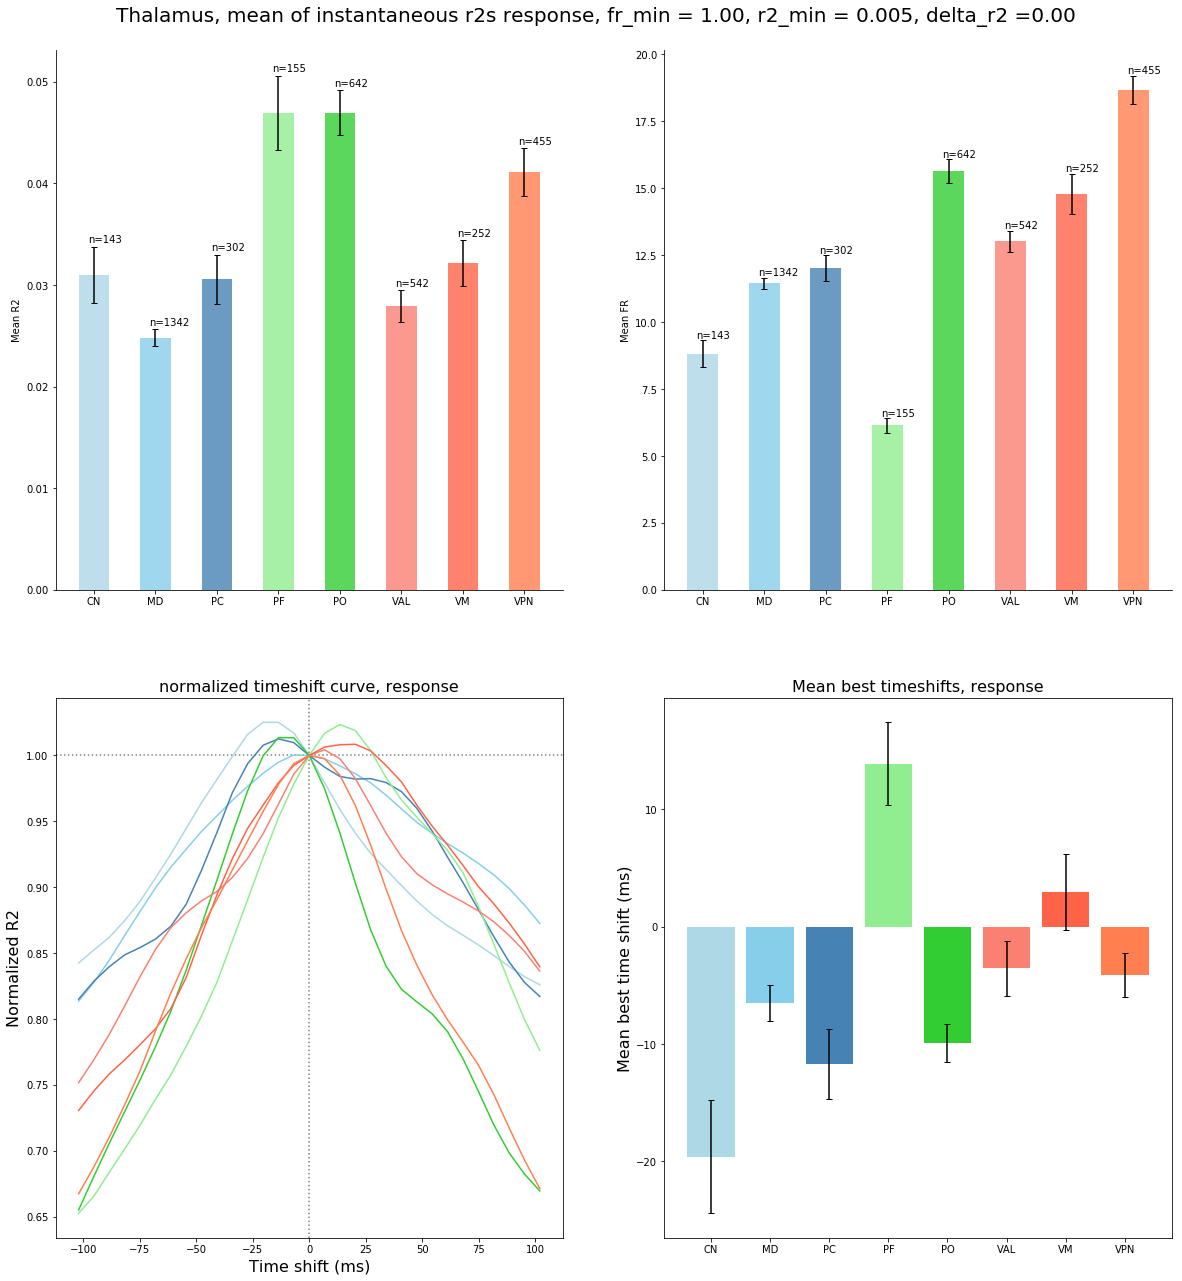

In [18]:
create_summary_plot(thalamus_use_nuclei, cc, r2_new, timeshifts, epochs,alm_inds=alm_inds, r2_method = 'new', axis_names = short_names, titlestr = 'Thalamus, mean of instantaneous r2s ', method_to_string = method_to_string, r2_threshold=0.005, fr_threshold=1.0, delta_r2=0.,n_min= 90)
plt.savefig(figfolder + 'thalamus_r2_response.pdf', bbox_inches = 'tight')

In [11]:
region_list = thalamus_use_nuclei
n_min = 140

inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
use_inds = {k: v for k,v in inds.items() if v.shape[0] > n_min}

In [14]:

epoch = 'response'
r2_method = 'new'
fr_threshold = 1.
r2_threshold = 0.005
region_list = thalamus_use_nuclei
n_min = 140

inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
r2 = []
fr = r2_new['5_0']['avg_fr'].copy()

for timesh in timeshifts:
    r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

r2 = np.array(r2)
if r2_method == 'old_clipped':
    r2[r2 < 0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
#delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
#threshold_inds = np.intersect1d(threshold_inds, delta_inds)

_inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

use_regions = list(use_inds.keys())
#use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]

In [15]:
best_times = 3.4 * timeshifts[np.argmax(r2, axis = 0)]

<ipython-input-17-f8f9020debff>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


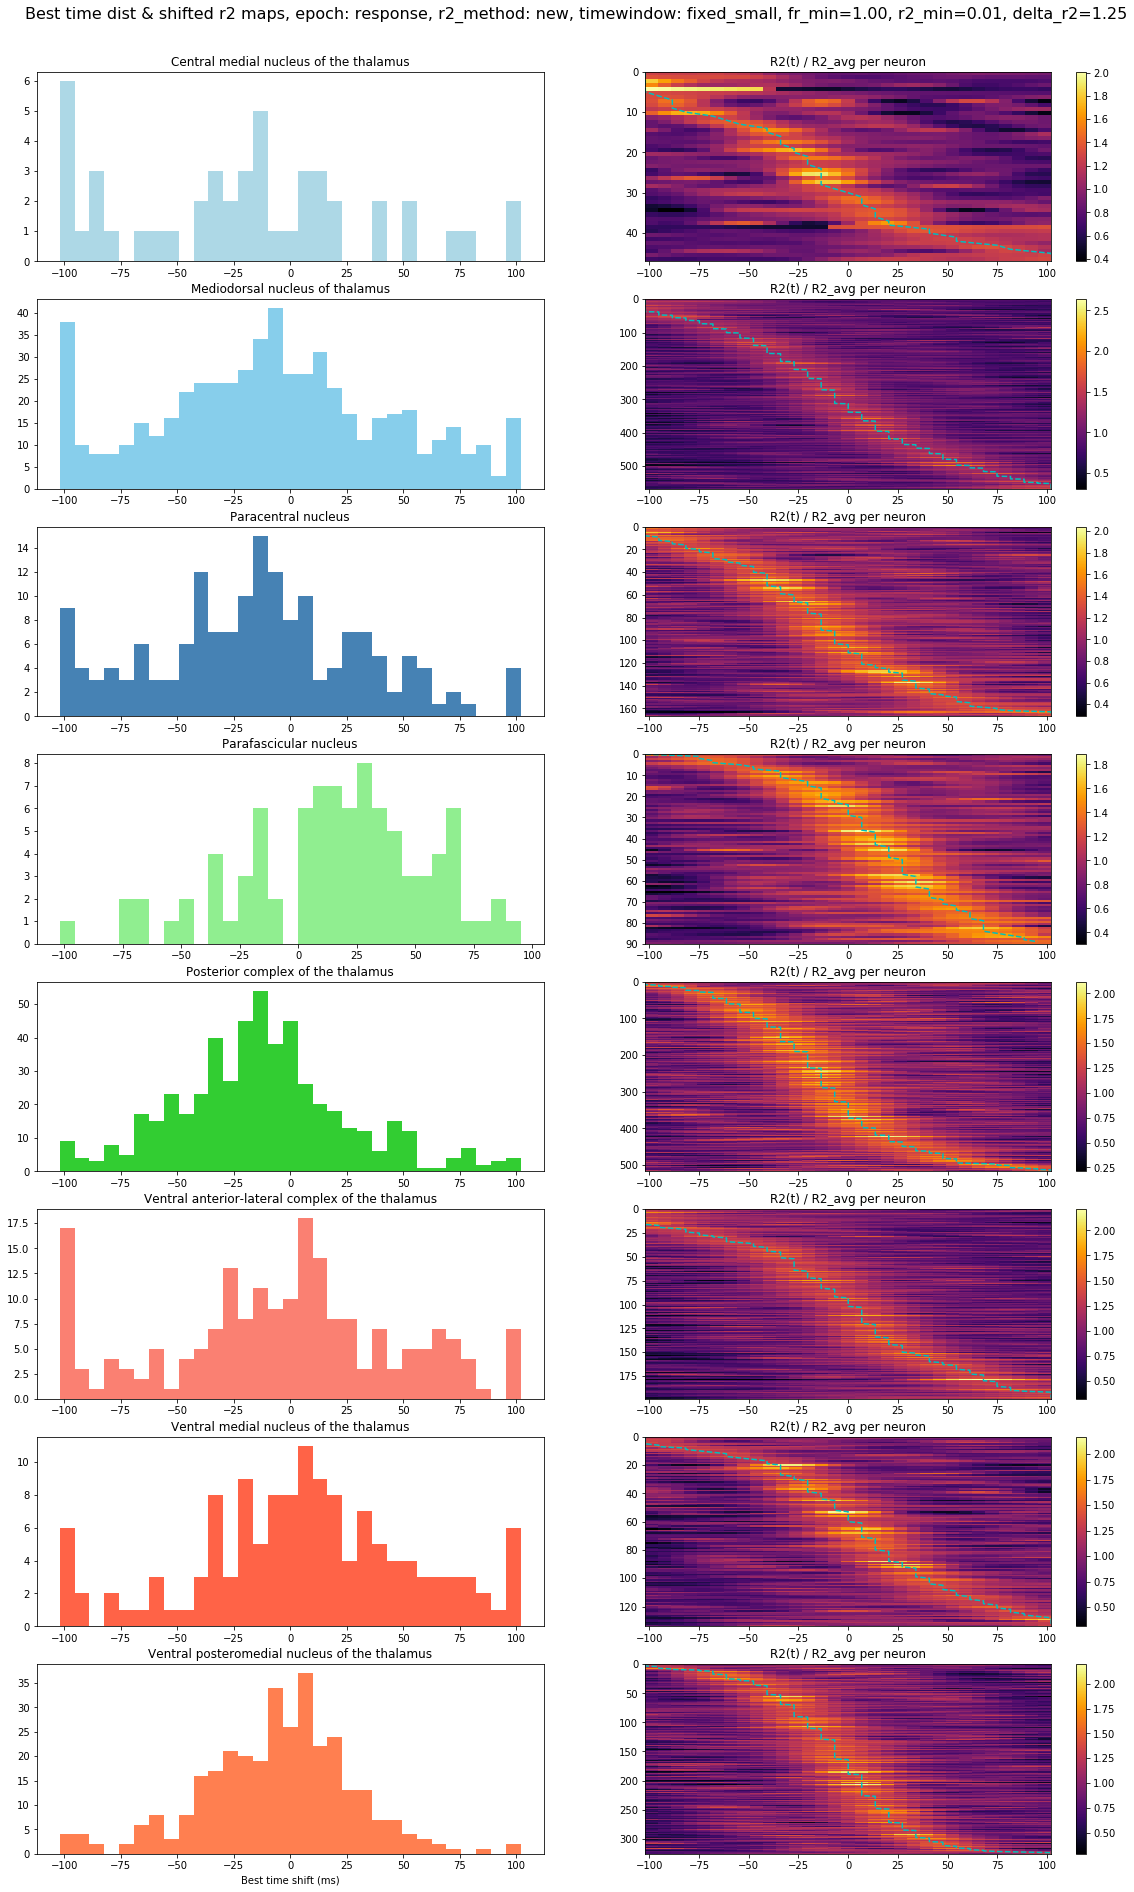

In [17]:
delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    plt.title(area)
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'thalamus_best_time_dist_and_r2_maps_response.pdf', bbox_inches = 'tight')

In [24]:
use_midbrain_list = [
    'Midbrain, sensory related',
    'Substantia nigra, reticular part',
    'Midbrain reticular nucleus',
    'Superior colliculus, motor related',
    #'Periaqueductal gray',
    #'Cuneiform nucleus',
    'Red nucleus',
    'Pretectal region',
    'Substantia nigra, compact part',
    'Pedunculopontine nucleus',
]

short_midbrain_names = [
    'Sensory',
    'SNR',
    'Reticular',
    'SCM',
    #'PG',
    'Red',
    'Pretectal',
    'SNC',
    'Pendunculopontine',
]

color_list = [
    "gray",
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",
    "red",
    "coral"
]

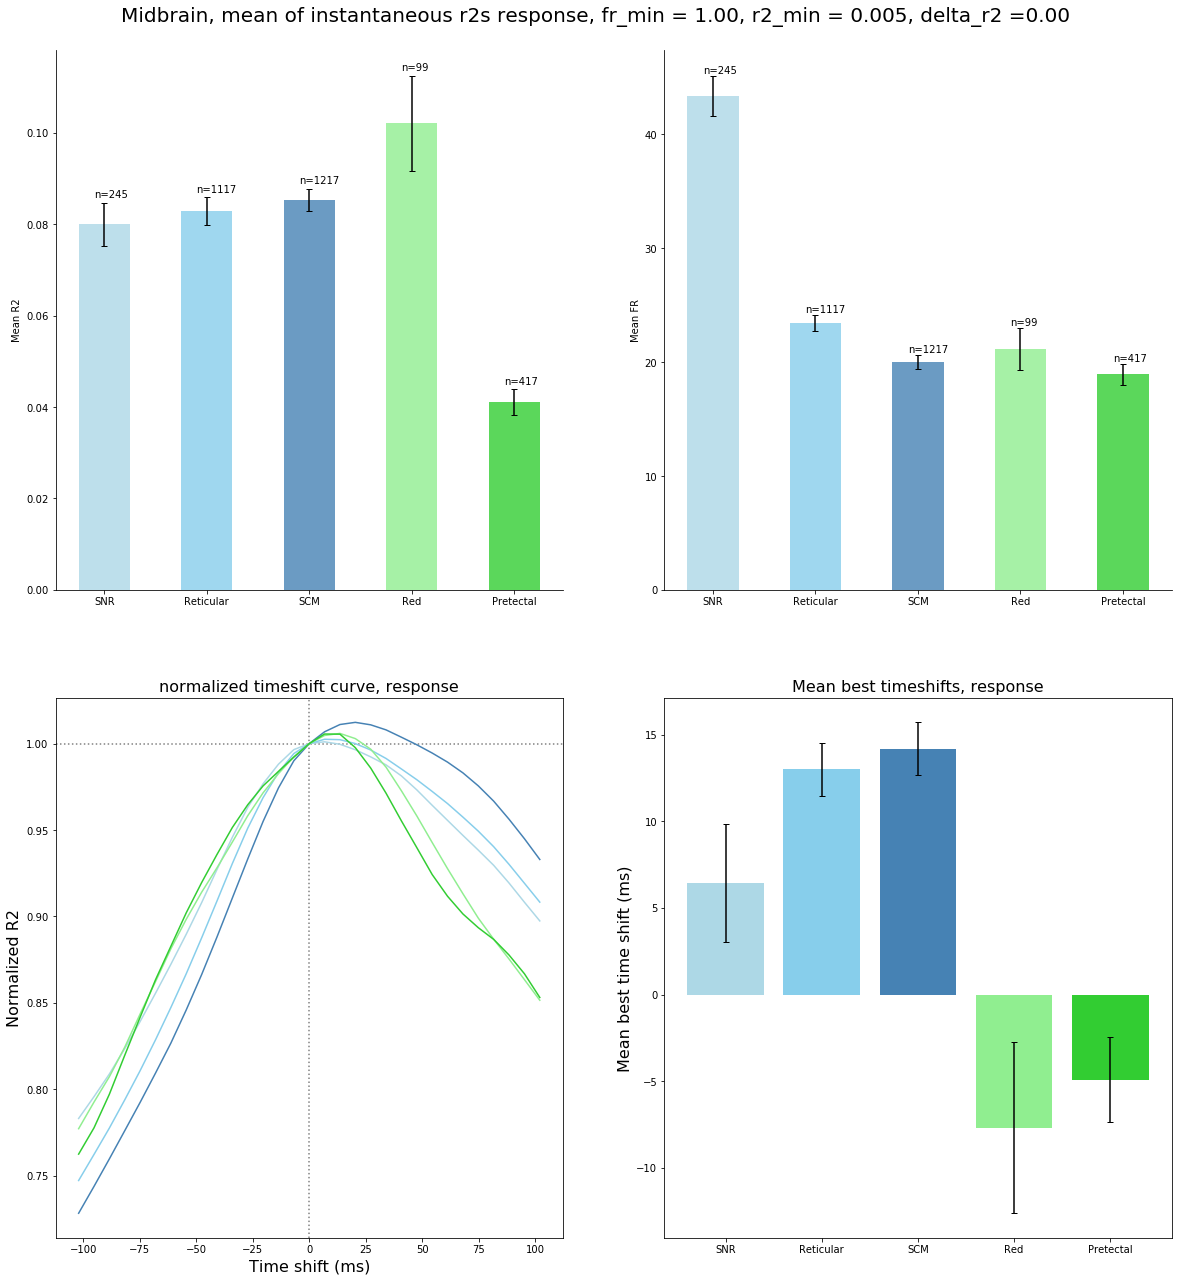

In [35]:
create_summary_plot(use_midbrain_list, cc, r2_new, timeshifts, epochs,alm_inds=alm_inds, r2_method = 'new', axis_names = short_midbrain_names, titlestr = 'Midbrain, mean of instantaneous r2s ', method_to_string = method_to_string, r2_threshold=0.005, fr_threshold=1.0, delta_r2=0.,n_min= 80)
plt.savefig(figfolder + 'midbrain_r2_response.pdf', bbox_inches = 'tight')

<ipython-input-30-7b4bb4af4ffa>:35: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


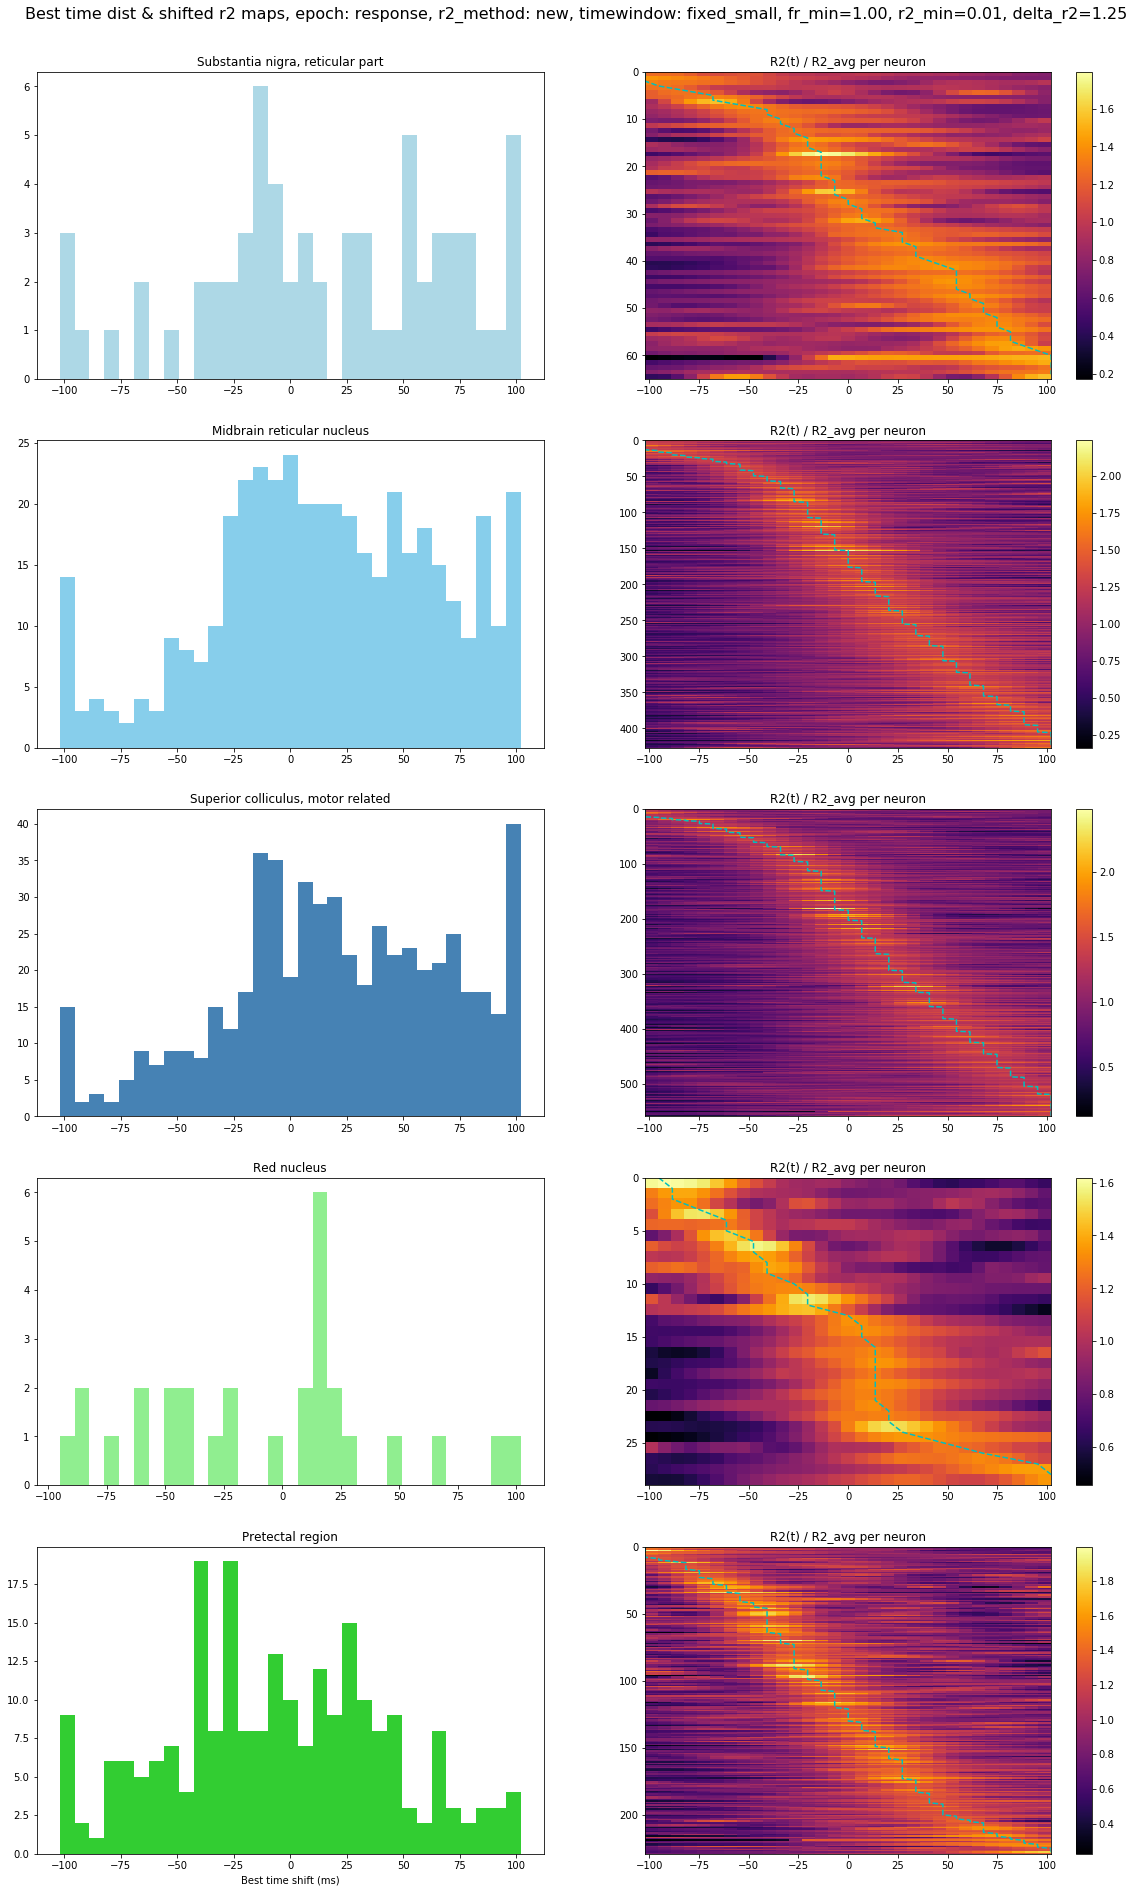

In [30]:

epoch = 'response'
r2_method = 'new'
fr_threshold = 1.
r2_threshold = 0.005
region_list = use_midbrain_list
n_min = 80

inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
r2 = []
fr = r2_new['5_0']['avg_fr'].copy()

for timesh in timeshifts:
    r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

r2 = np.array(r2)
if r2_method == 'old_clipped':
    r2[r2 < 0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
#delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
#threshold_inds = np.intersect1d(threshold_inds, delta_inds)

_inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

use_regions = list(use_inds.keys())
#use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]

best_times = 3.4 * timeshifts[np.argmax(r2, axis = 0)]

delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    plt.title(area)
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'midbrain_best_time_dist_and_r2_maps_response.pdf', bbox_inches = 'tight')

In [37]:
use_cortex_list = ['ALM',
                   'Somatosensory areas',
                   'Somatomotor areas',
                   'Auditory areas',
                   'Orbital area',
                   'Agranular insular area',
                   'Retrosplenial area',]

col_list = [
    "lightblue",    # Some kind of blue
    "skyblue",      # Some kind of blue
    "steelblue",    # Some kind of blue
    "lightgreen",   # Some kind of green
    "limegreen",    # Some kind of green
    "salmon",
    "tomato",
    "coral"
]

short_cortex_names = [
    'ALM',
    'Somatosensory',
    'Somatomotor',
    'Auditory',
    'Orbital',
    'Angular',
    'Retrosplenial',
]

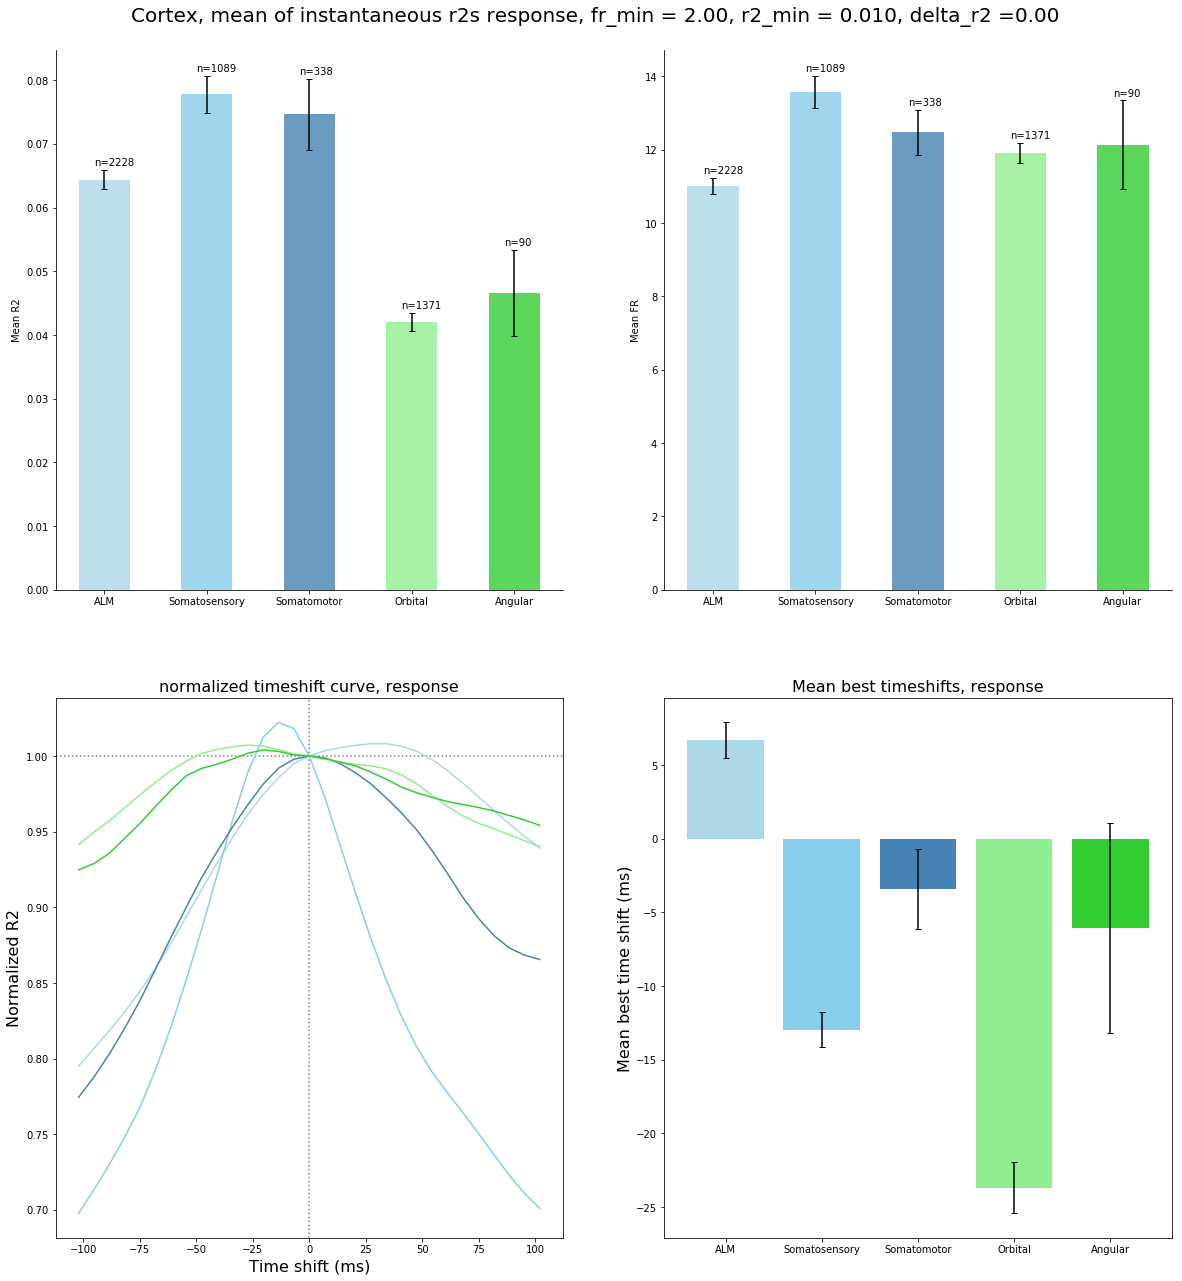

In [45]:
create_summary_plot(use_cortex_list, cc, r2_new, timeshifts, epochs,alm_inds=alm_inds, r2_method = 'new', axis_names = short_cortex_names, titlestr = 'Cortex, mean of instantaneous r2s ', method_to_string = method_to_string, r2_threshold=0.01, fr_threshold=2.0, delta_r2=0.,n_min= 80)
plt.savefig(figfolder + 'cortex_r2_response.pdf', bbox_inches = 'tight')

<ipython-input-46-b02c80c73dd2>:35: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


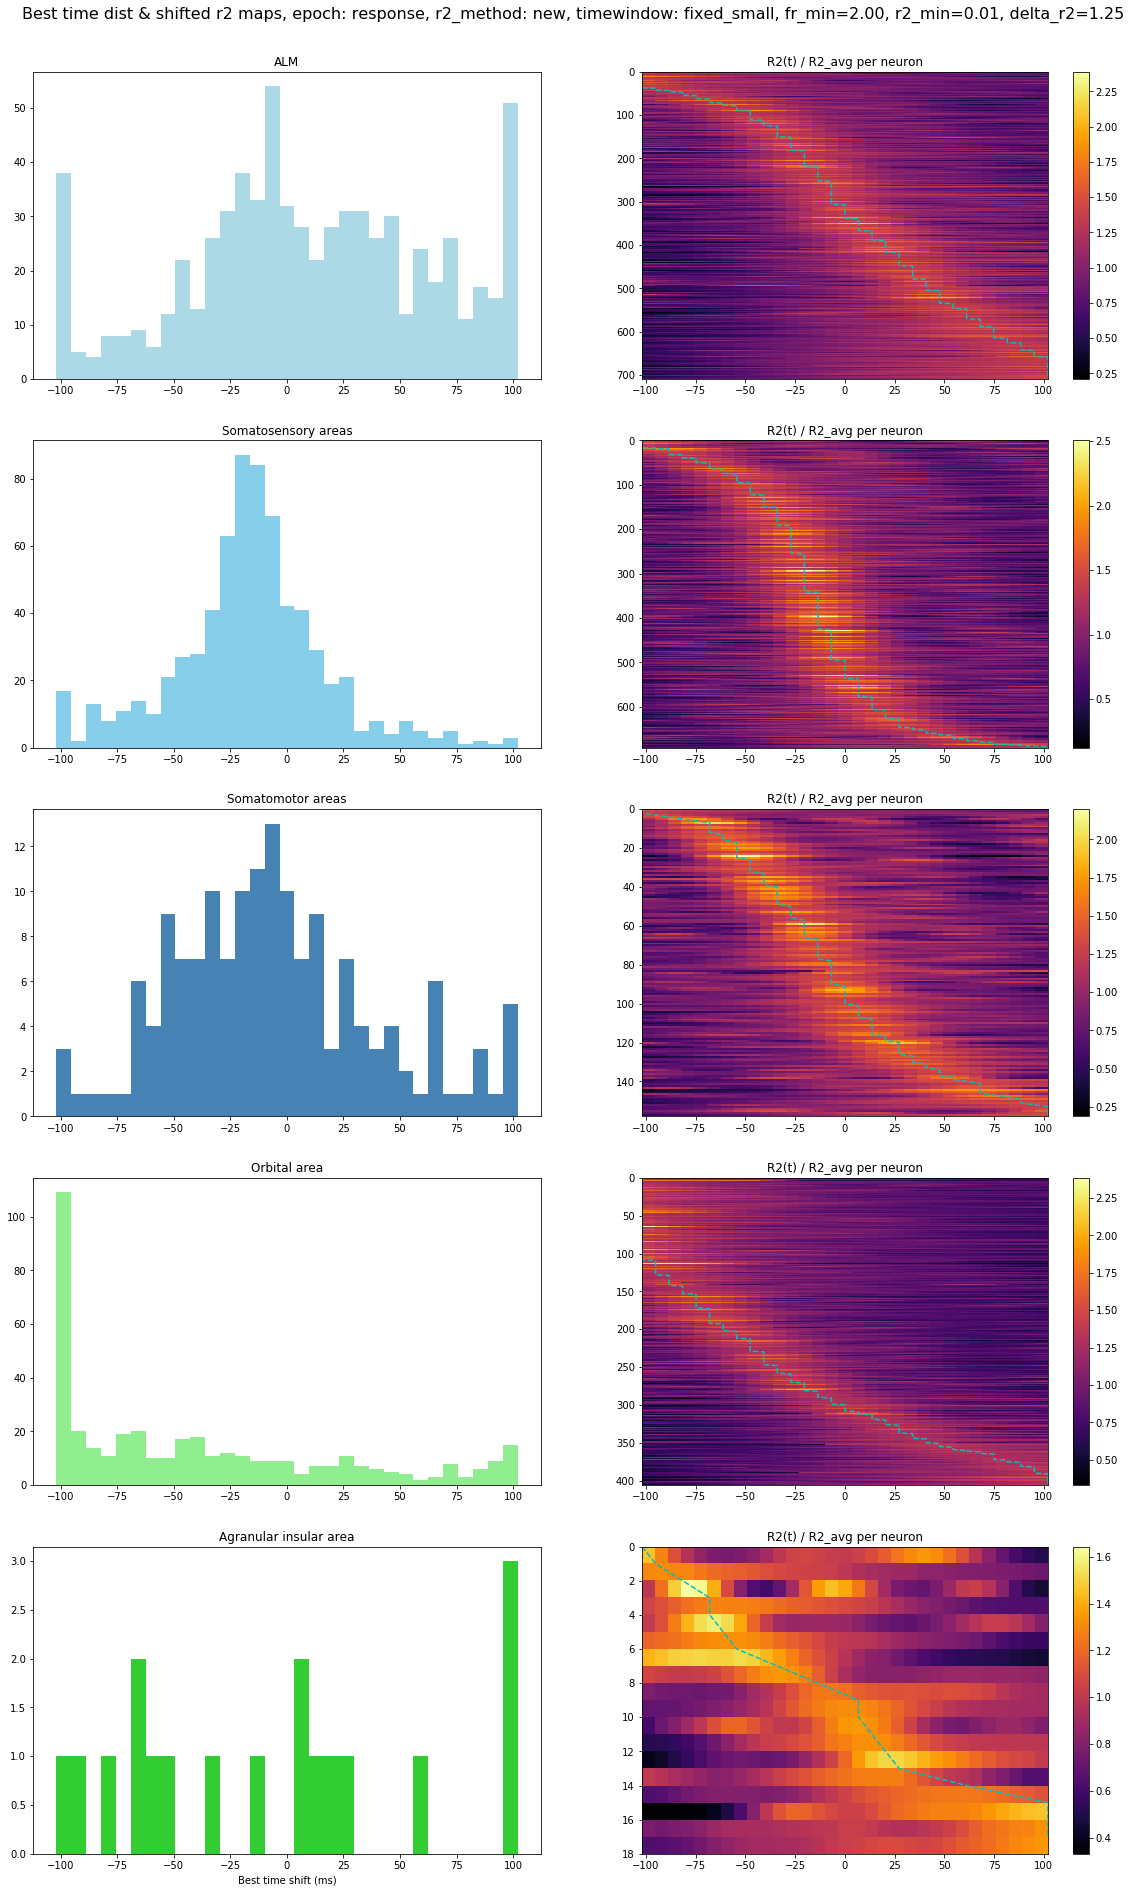

In [46]:

epoch = 'response'
r2_method = 'new'
fr_threshold = 2.
r2_threshold = 0.01
region_list = use_cortex_list
n_min = 80

inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
r2 = []
fr = r2_new['5_0']['avg_fr'].copy()

for timesh in timeshifts:
    r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

r2 = np.array(r2)
if r2_method == 'old_clipped':
    r2[r2 < 0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
#delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
#threshold_inds = np.intersect1d(threshold_inds, delta_inds)

_inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

use_regions = list(use_inds.keys())
#use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]

best_times = 3.4 * timeshifts[np.argmax(r2, axis = 0)]

delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    plt.title(area)
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'cortex_best_time_dist_and_r2_maps_response.pdf', bbox_inches = 'tight')

In [47]:
medulla_use_nuclei = [
    'Medulla, sensory related',
    'Gigantocellular reticular nucleus',
    'Intermediate reticular nucleus',
    'Magnocellular reticular nucleus',
    'Parvicellular reticular nucleus',
    'Vestibular nuclei',
]

medulla_short_names = [
    'Sensory medulla',
    'Gigantocellular',
    'Intermediate',
    'Magnocellular',
    'Parvicellular',
    'Vestibular'
]

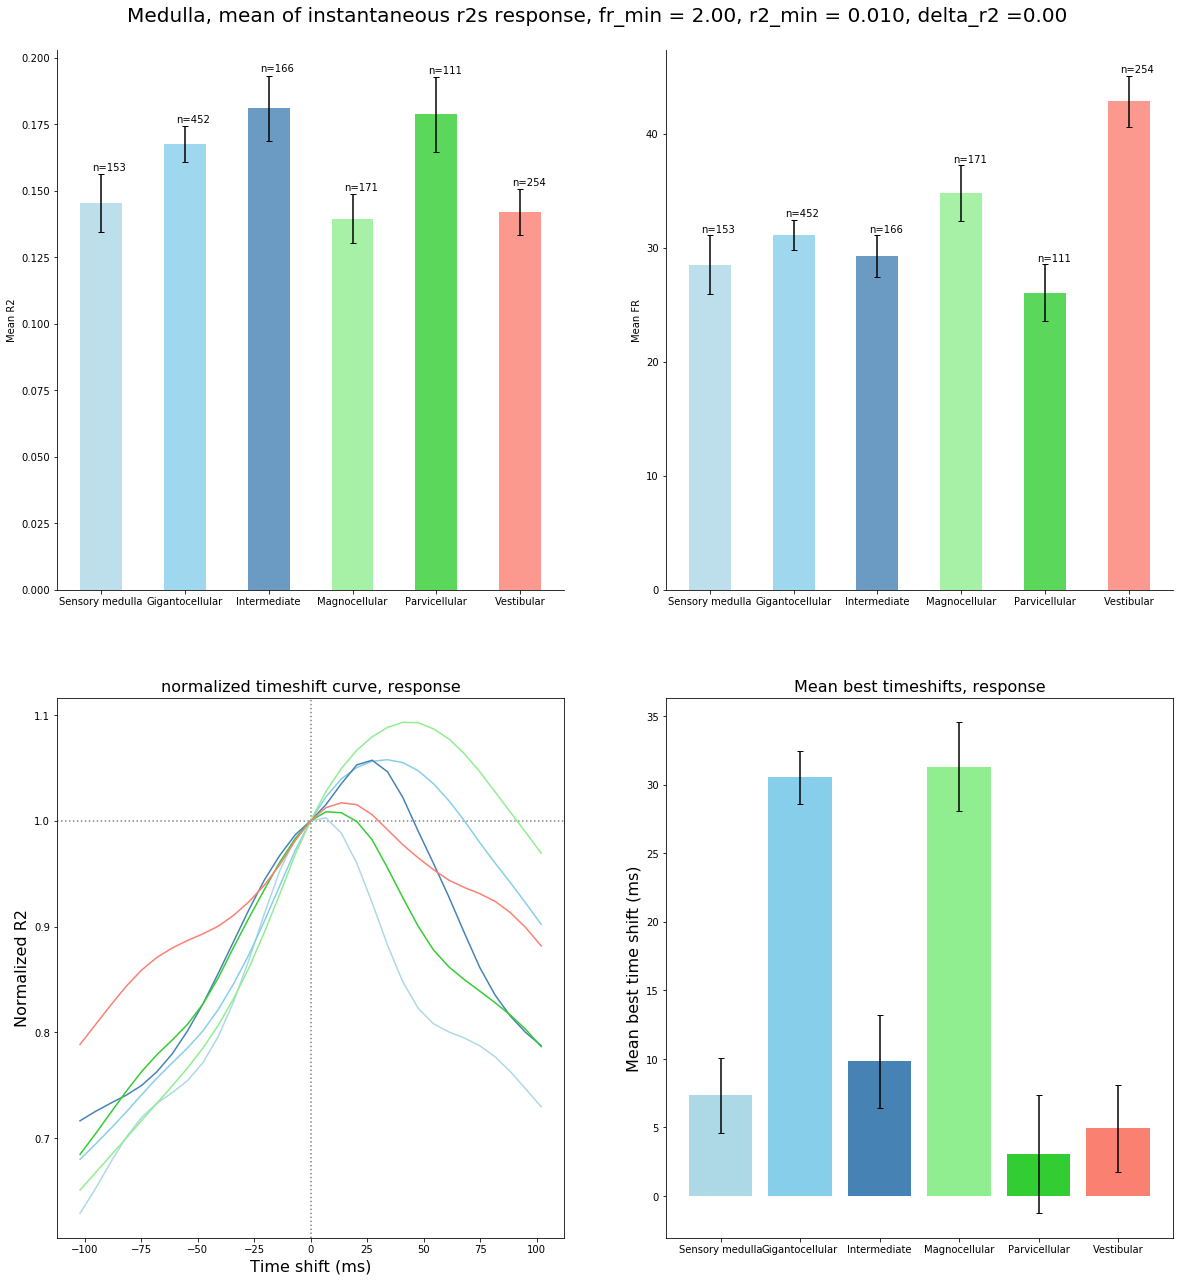

In [48]:
create_summary_plot(medulla_use_nuclei, cc, r2_new, timeshifts, epochs,alm_inds=alm_inds, r2_method = 'new', axis_names = medulla_short_names, titlestr = 'Medulla, mean of instantaneous r2s ', method_to_string = method_to_string, r2_threshold=0.01, fr_threshold=2.0, delta_r2=0.,n_min= 80)
plt.savefig(figfolder + 'medulla_r2_response.pdf', bbox_inches = 'tight')

<ipython-input-49-f6236db73046>:35: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


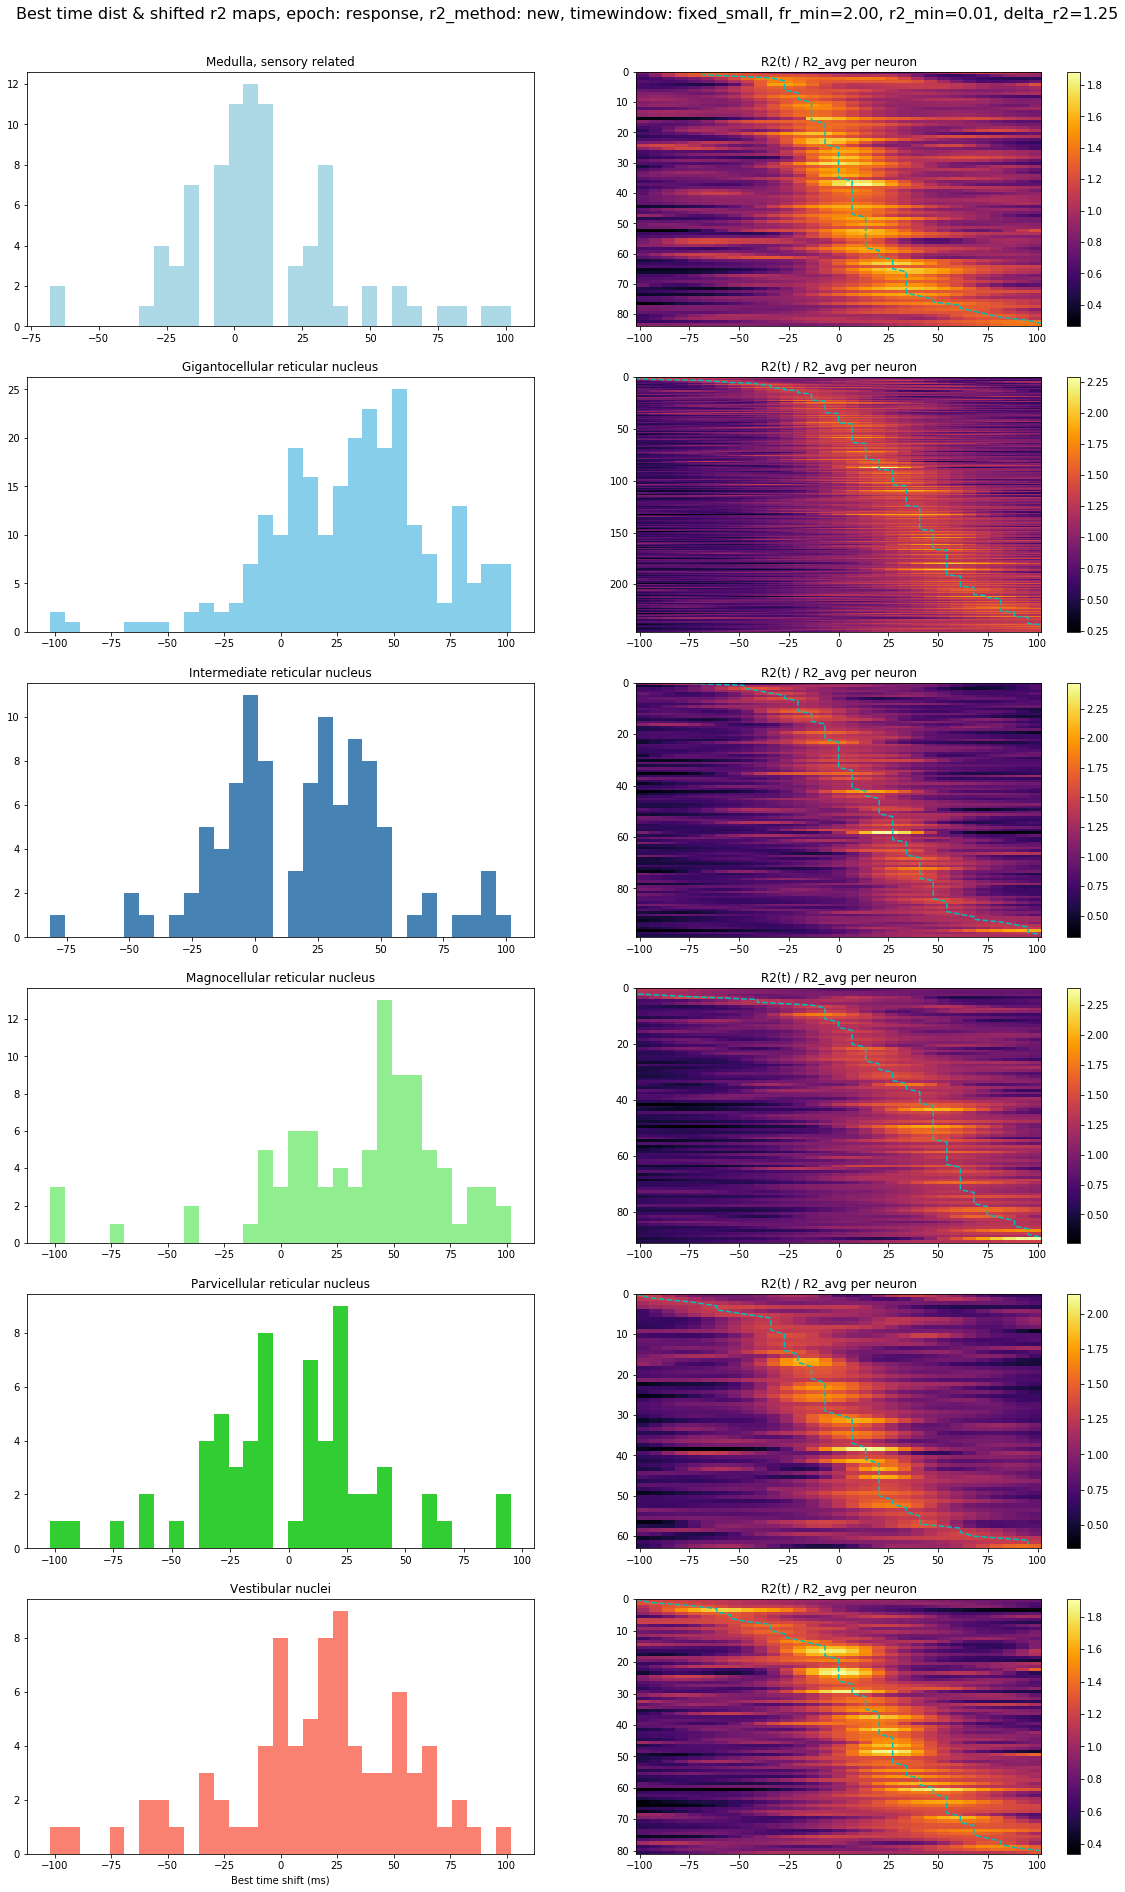

In [49]:

epoch = 'response'
r2_method = 'new'
fr_threshold = 2.
r2_threshold = 0.01
region_list = medulla_use_nuclei
n_min = 80

inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
r2 = []
fr = r2_new['5_0']['avg_fr'].copy()

for timesh in timeshifts:
    r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

r2 = np.array(r2)
if r2_method == 'old_clipped':
    r2[r2 < 0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
#delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
#threshold_inds = np.intersect1d(threshold_inds, delta_inds)

_inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

use_regions = list(use_inds.keys())
#use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]

best_times = 3.4 * timeshifts[np.argmax(r2, axis = 0)]

delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    plt.title(area)
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'medulla_best_time_dist_and_r2_maps_response.pdf', bbox_inches = 'tight')

In [50]:
# Striatum

Striatum_subregions = func.get_n_layer_down_subregions_from_name(df, 'Striatum', 1)['region'].values
Striatum_subregions_annotations = {}
for subregion in Striatum_subregions:
    Striatum_subregions_annotations[subregion] = func.get_all_subregion_annotations_from_name(df, subregion)['region'].values
inds = func.get_neuron_inds_for_subregions(ccf_labels, Striatum_subregions_annotations)
medial_lateral_cutoff = 2500

dorsal_inds = {'Striatum dorsal region, medial': [], 'Striatum dorsal region, lateral': []}
for ii in inds['Striatum dorsal region']:
    ccf_x = ccf_coords[ii][0]
    if np.abs(ccf_x ) < medial_lateral_cutoff:
        dorsal_inds['Striatum dorsal region, medial'].append(ii)
    elif np.abs(ccf_x ) > medial_lateral_cutoff:
        dorsal_inds['Striatum dorsal region, lateral'].append(ii)

joint_inds = {}
for k in dorsal_inds.keys():
    joint_inds[k] = np.array(dorsal_inds[k])

for k in inds.keys():
    if k != 'Striatum dorsal region':
        joint_inds[k] = inds[k]

use_Striatum_nuclei = list(joint_inds.keys())

joint_color_list = ['grey', 'black', 'blue', 'green']

In [51]:
use_Striatum_nuclei

['Striatum dorsal region, medial',
 'Striatum dorsal region, lateral',
 'Striatum ventral region',
 'Lateral septal complex',
 'Striatum-like amygdalar nuclei']

In [52]:
striatum_short_names = [
    'Dorsal medial',
    'Dorsal lateral',
    'Ventral',
    'Lateral septal',
    'Str-like amyg'
]

In [55]:
fr_threshold = 2
r2_threshold = 0.01
delta_r2 = 0.
n_min = 80

axis_names = striatum_short_names
titlestr = 'Striatum mean of instantaenous r2, '
inds = joint_inds
region_list = use_Striatum_nuclei


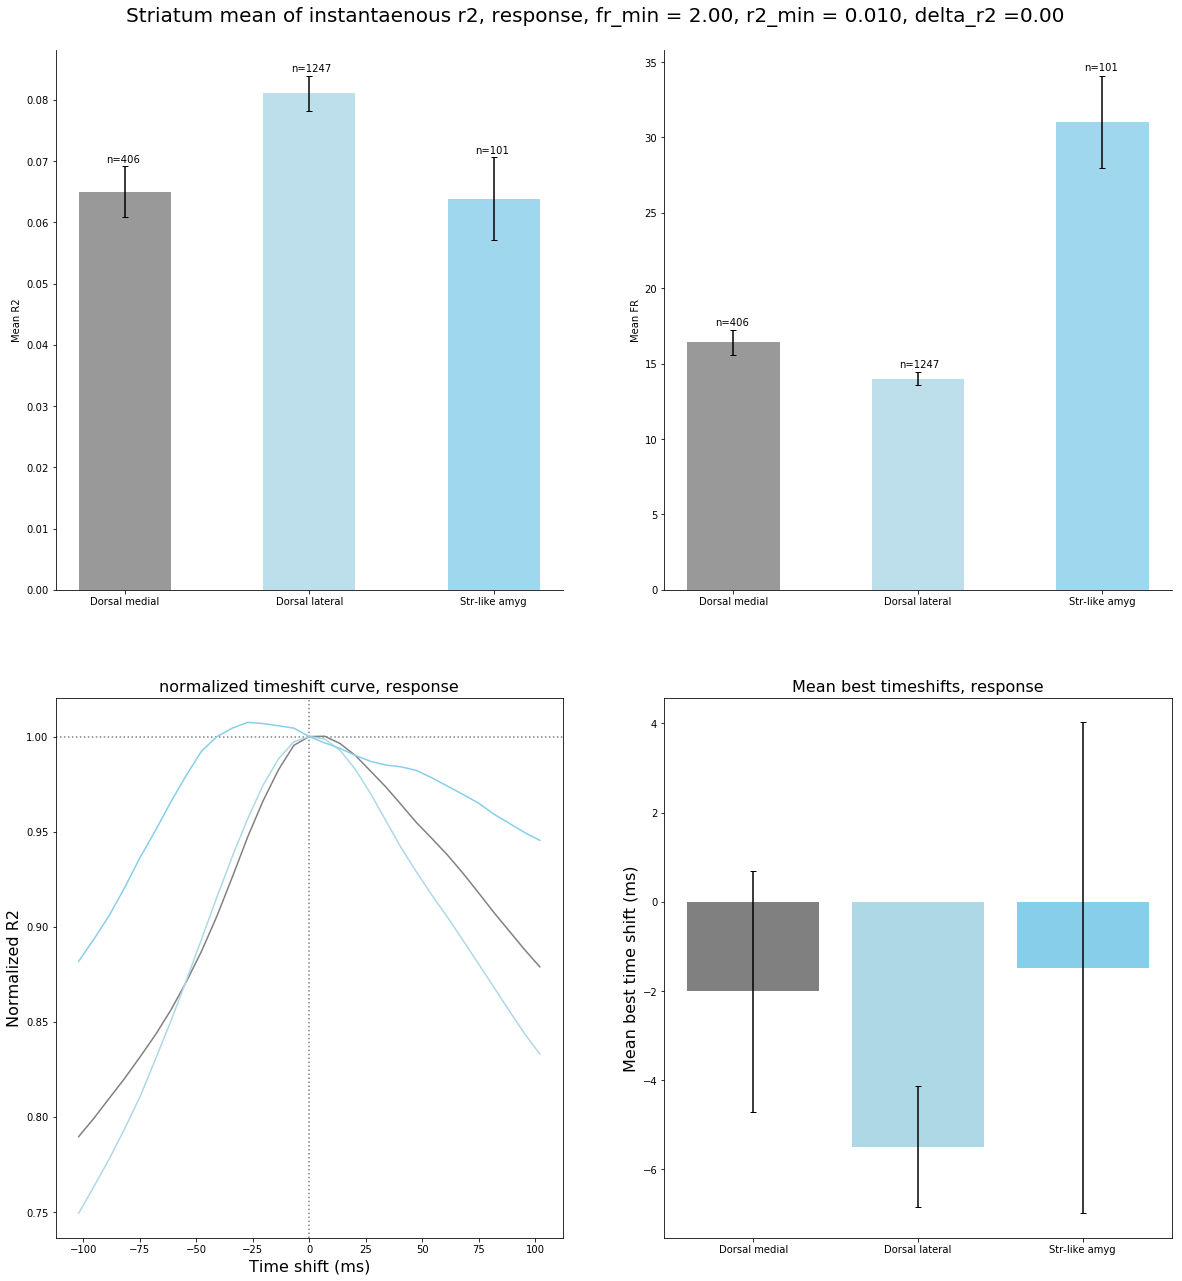

In [57]:
r2 = []
fr = r2_new['5_0']['avg_fr'].copy()

for timesh in timeshifts:
    r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

r2 = np.array(r2)
if r2_method == 'old_clipped':
    r2[r2 < 0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
#delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
#threshold_inds = np.intersect1d(threshold_inds, delta_inds)

_inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

use_regions = list(use_inds.keys())

use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]
f = plt.figure(figsize=(20,20))
f.suptitle(titlestr + '%s, fr_min = %.2f, r2_min = %.3f, delta_r2 =%.2f'%(epoch,fr_threshold,r2_threshold,delta_r2), fontsize=20)

ax_bar = f.add_subplot(2,2,1)
create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean R2', 'r2', r2_method, epoch,)

ax_bar = f.add_subplot(2,2,2)
create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean FR', 'fr', r2_method, epoch,)

ax_bar = f.add_subplot(2,2,3)
create_timeshift_curves_plot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch)

ax_bar = f.add_subplot(2,2,4)
create_timeshift_barplot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch,)
plt.subplots_adjust(top=0.95)


plt.savefig(figfolder + 'striatum_r2_response.pdf', bbox_inches = 'tight')

Striatum dorsal region, medial (406,)
Striatum dorsal region, lateral (1247,)
Striatum ventral region (27,)
Lateral septal complex (0,)
Striatum-like amygdalar nuclei (101,)


<ipython-input-64-79ba34982682>:39: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


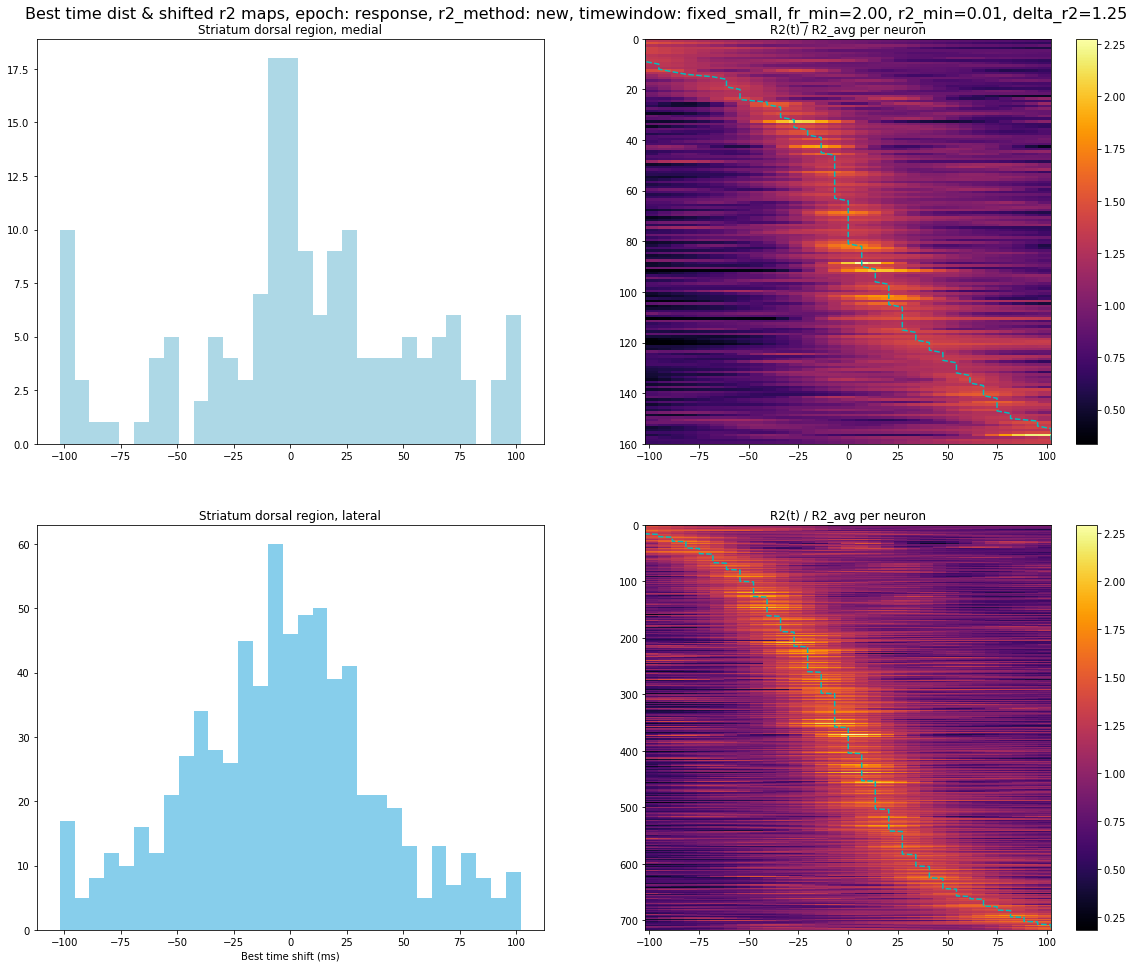

In [64]:

epoch = 'response'
r2_method = 'new'
fr_threshold = 2.
r2_threshold = 0.01
region_list = use_Striatum_nuclei
n_min = 110

inds = joint_inds


r2 = []
fr = r2_new['5_0']['avg_fr'].copy()

for timesh in timeshifts:
    r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

r2 = np.array(r2)
if r2_method == 'old_clipped':
    r2[r2 < 0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
#delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
#threshold_inds = np.intersect1d(threshold_inds, delta_inds)

_inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
for k,v in _inds.items():
    print(k,v.shape)
use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

use_regions = list(use_inds.keys())
#use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]

best_times = 3.4 * timeshifts[np.argmax(r2, axis = 0)]

delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,15))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    plt.title(area)
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'striatum_best_time_dist_and_r2_maps_response.pdf', bbox_inches = 'tight')

#### 2D maps

In [6]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 1, 1), (1, 1, 0), (1, 0, 0)]  # Blue -> White -> Yellow -> Red
positions = [-50, 0, 50, 100]

# Normalize positions to the range [0, 1]
norm_positions = [(pos - positions[0]) / (positions[-1] - positions[0]) for pos in positions]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_positions, colors)))

In [7]:
def get_2D_grid_averages(best_times, ccf_coords, voxel_size = 300, projection_axis = 0):
    # Project ccf_coords onto the 2D plane
    coords_2d = np.delete(ccf_coords, projection_axis, axis=1)
    
    # Calculate the voxel indices for each point
    voxel_indices = np.floor(coords_2d / voxel_size).astype(int)
    
    # Find the bounds for the grid
    min_indices = np.min(voxel_indices, axis=0)
    max_indices = np.max(voxel_indices, axis=0)
    grid_shape = max_indices - min_indices + 1
    
    # Initialize a grid to store the sum and count of best_times for averaging
    sum_grid = np.zeros(grid_shape)
    count_grid = np.zeros(grid_shape)
    
    # Populate the grids with summed times and counts
    for index, time in zip(voxel_indices, best_times):
        normalized_index = tuple(index - min_indices)  # Normalize indices to start from 0,0
        sum_grid[normalized_index] += time
        count_grid[normalized_index] += 1
    
    # Calculate the average best time for each voxel
    with np.errstate(invalid='ignore'):  # Ignore divisions by 0
        avg_grid = np.divide(sum_grid, count_grid)
        avg_grid[np.isnan(avg_grid)] = 0  # Replace NaNs with 0
    
    return avg_grid, min_indices, max_indices

In [8]:
epoch = 'response'
r2_method = 'new'
timewindow_cut = 'fixed_small'

fr = r2_new['5_0']['avg_fr'].copy()
r2 = []

for timesh in timeshifts:
    r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

r2 = np.array(r2)
# there are no negative values in the new method
#r2[r2<0] = 0

best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]

In [9]:
delta_r2 = 1.25
fr_threshold = 2.
r2_threshold = 0.01



delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
restriction_inds = np.intersect1d(threshold_inds, delta_inds)

<ipython-input-9-9131bfdbad37>:7: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


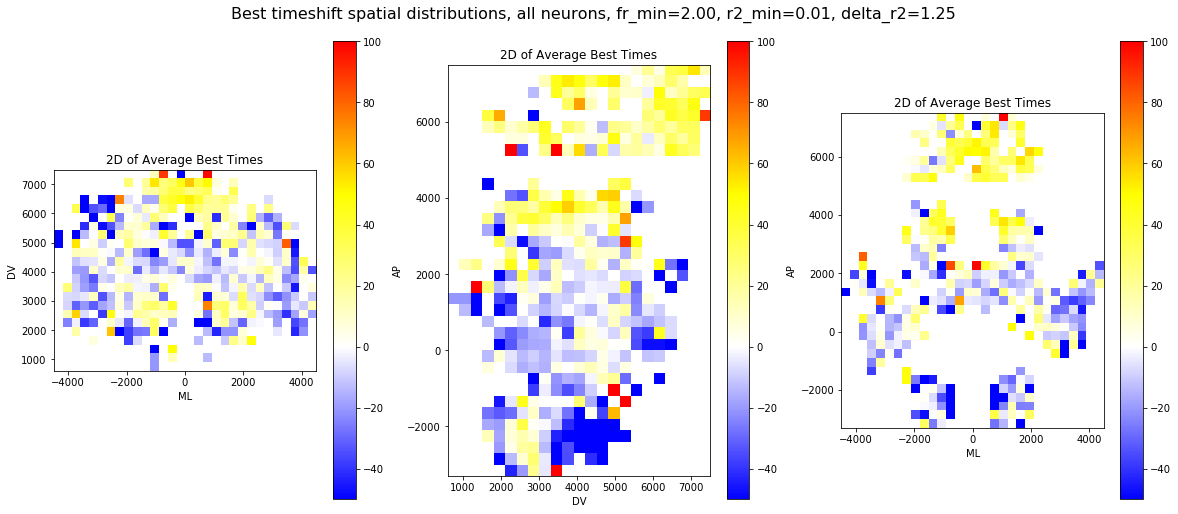

In [10]:
f,_ = plt.subplots(1,3, figsize = (20,8))
f.suptitle('Best timeshift spatial distributions, all neurons, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(fr_threshold,r2_threshold,delta_r2), fontsize = 16)

voxel_size = 300

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 2)


plt.subplot(1,3,1)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 0)


plt.subplot(1,3,2)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 1)


plt.subplot(1,3,3)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

plt.subplots_adjust(top = 0.92)
#plt.savefig(figfolder + 'Best_timeshift_spatial_distributions_all.pdf',bbox_inches = 'tight')

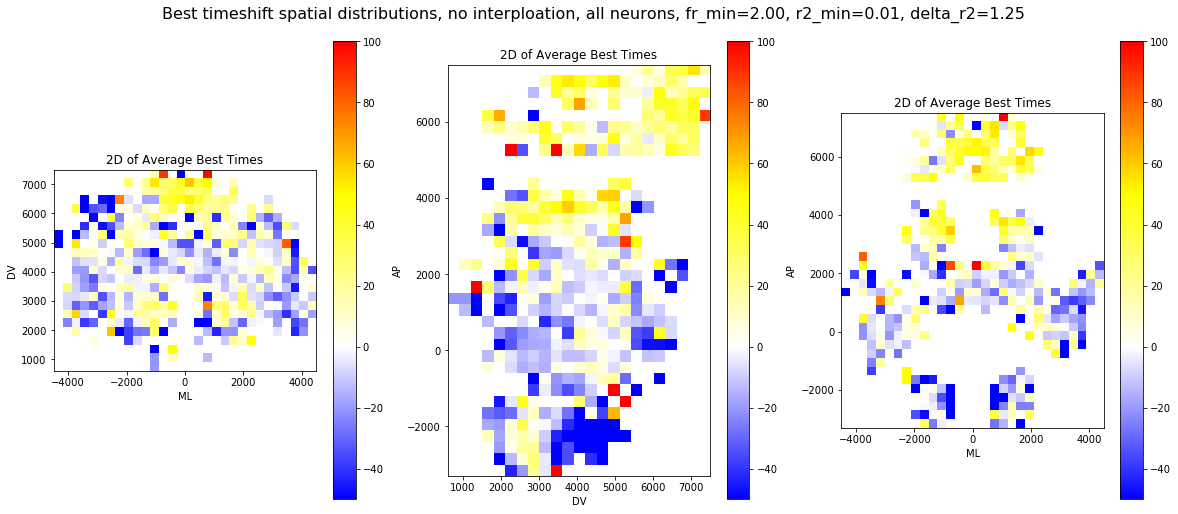

In [11]:
f,_ = plt.subplots(1,3, figsize = (20,8))
f.suptitle('Best timeshift spatial distributions, no interploation, all neurons, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(fr_threshold,r2_threshold,delta_r2), fontsize = 16)

voxel_size = 300

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 2)


plt.subplot(1,3,1)
plt.imshow(avg_grid.T,origin='lower',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 0)


plt.subplot(1,3,2)
plt.imshow(avg_grid.T,origin='lower',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 1)


plt.subplot(1,3,3)
plt.imshow(avg_grid.T,origin='lower',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

plt.subplots_adjust(top = 0.92)
#plt.savefig(figfolder + 'Best_timeshift_spatial_distributions_all_nointerpolation.pdf',bbox_inches = 'tight')

Text(0.5,1,'Only negative timeshift neurons')

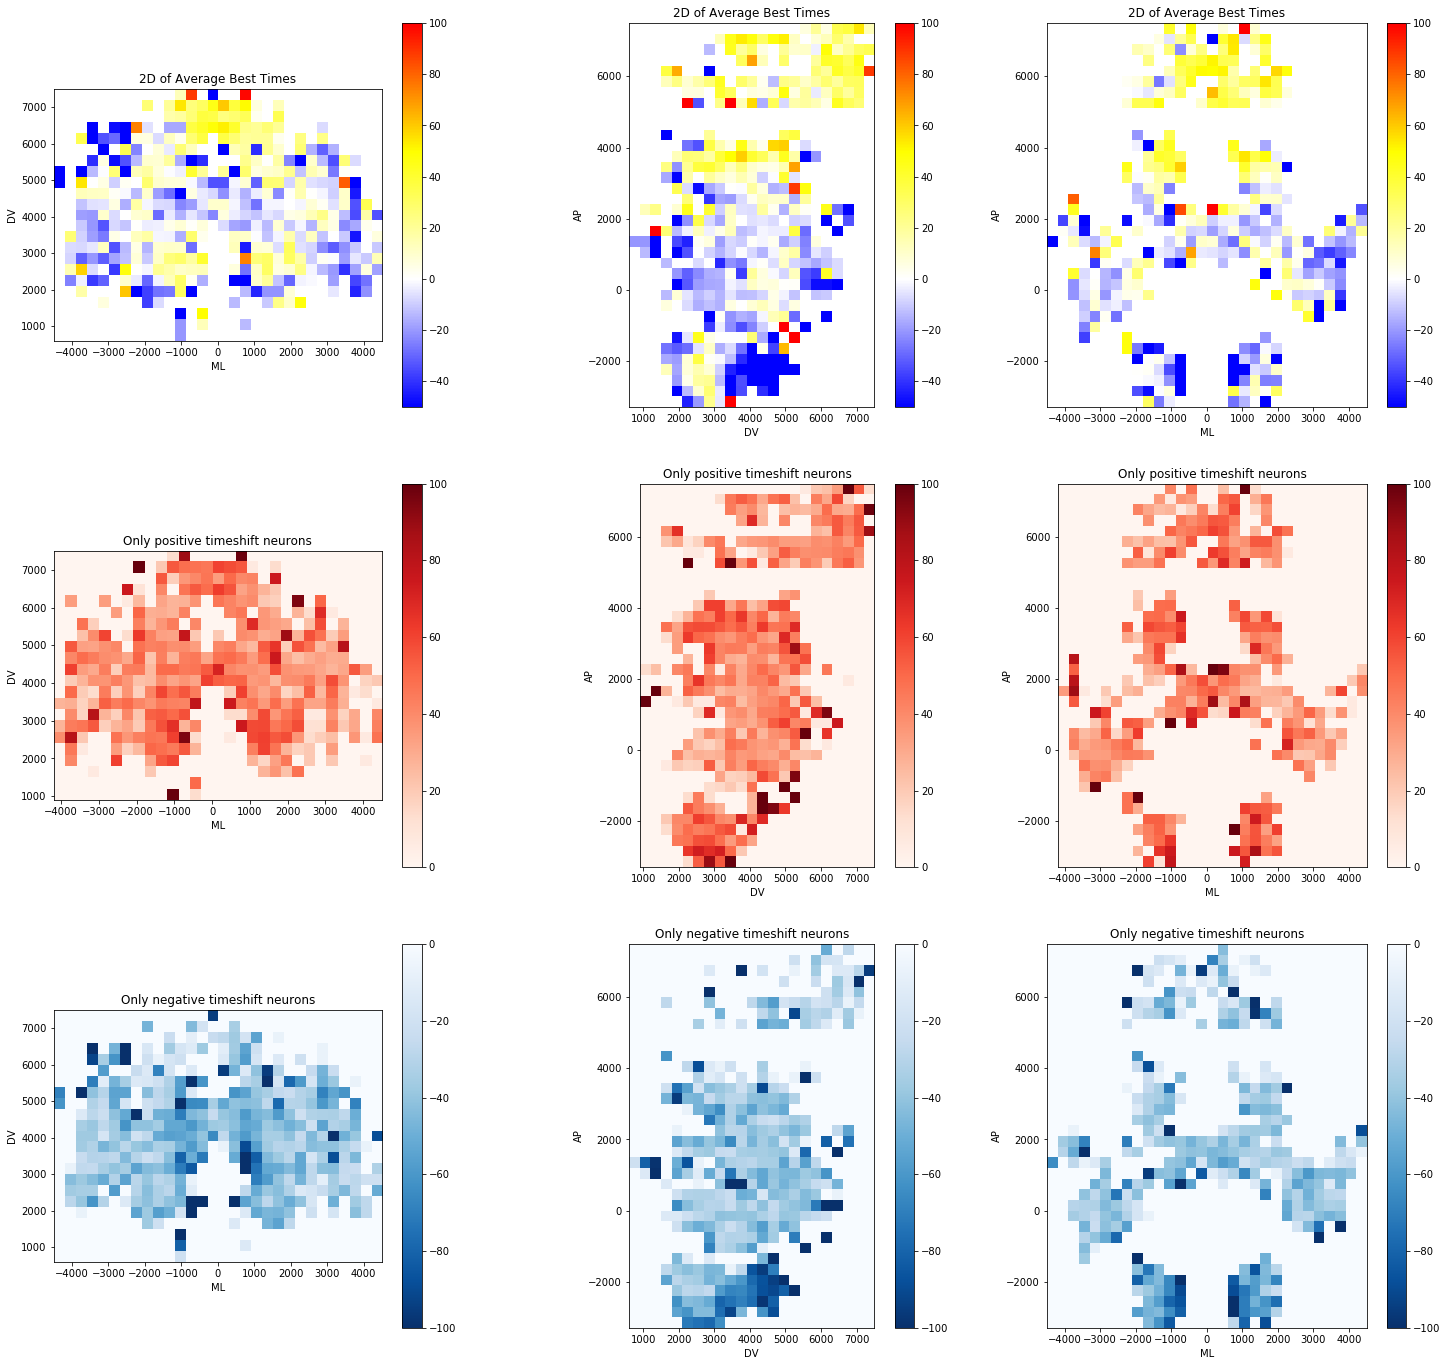

In [12]:
plt.subplots(3,3, figsize = (25,24))



# Define voxel size for the 2D plane
voxel_size = 300
avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 2)


plt.subplot(3,3,1)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 0)


plt.subplot(3,3,2)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 1)


plt.subplot(3,3,3)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

pos_inds = np.where(best_times[restriction_inds] > 0)[0]

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 2)


plt.subplot(3,3,4)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Only positive timeshift neurons')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 0)


plt.subplot(3,3,5)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Only positive timeshift neurons')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 1)


plt.subplot(3,3,6)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Only positive timeshift neurons')

neg_inds = np.where(best_times[restriction_inds] < 0)[0]
avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 2)


plt.subplot(3,3,7)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Only negative timeshift neurons')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 0)


plt.subplot(3,3,8)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Only negative timeshift neurons')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 1)


plt.subplot(3,3,9)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Only negative timeshift neurons')

#plt.savefig(figfolder + 'best_times_spatial_distributions_all_pos_neg.pdf', bbox_inches='tight')


In [13]:
def get_2D_grid_averages_with_count(best_times, ccf_coords, voxel_size = 300, projection_axis = 0):
    # Project ccf_coords onto the 2D plane
    coords_2d = np.delete(ccf_coords, projection_axis, axis=1)
    
    # Calculate the voxel indices for each point
    voxel_indices = np.floor(coords_2d / voxel_size).astype(int)
    
    # Find the bounds for the grid
    min_indices = np.min(voxel_indices, axis=0)
    max_indices = np.max(voxel_indices, axis=0)
    grid_shape = max_indices - min_indices + 1
    
    # Initialize a grid to store the sum and count of best_times for averaging
    sum_grid = np.zeros(grid_shape)
    count_grid = np.zeros(grid_shape)
    
    # Populate the grids with summed times and counts
    for index, time in zip(voxel_indices, best_times):
        normalized_index = tuple(index - min_indices)  # Normalize indices to start from 0,0
        sum_grid[normalized_index] += time
        count_grid[normalized_index] += 1
    
    # Calculate the average best time for each voxel
    with np.errstate(invalid='ignore'):  # Ignore divisions by 0
        avg_grid = np.divide(sum_grid, count_grid)
        avg_grid[np.isnan(avg_grid)] = 0  # Replace NaNs with 0
    
    return avg_grid, min_indices, max_indices, count_grid

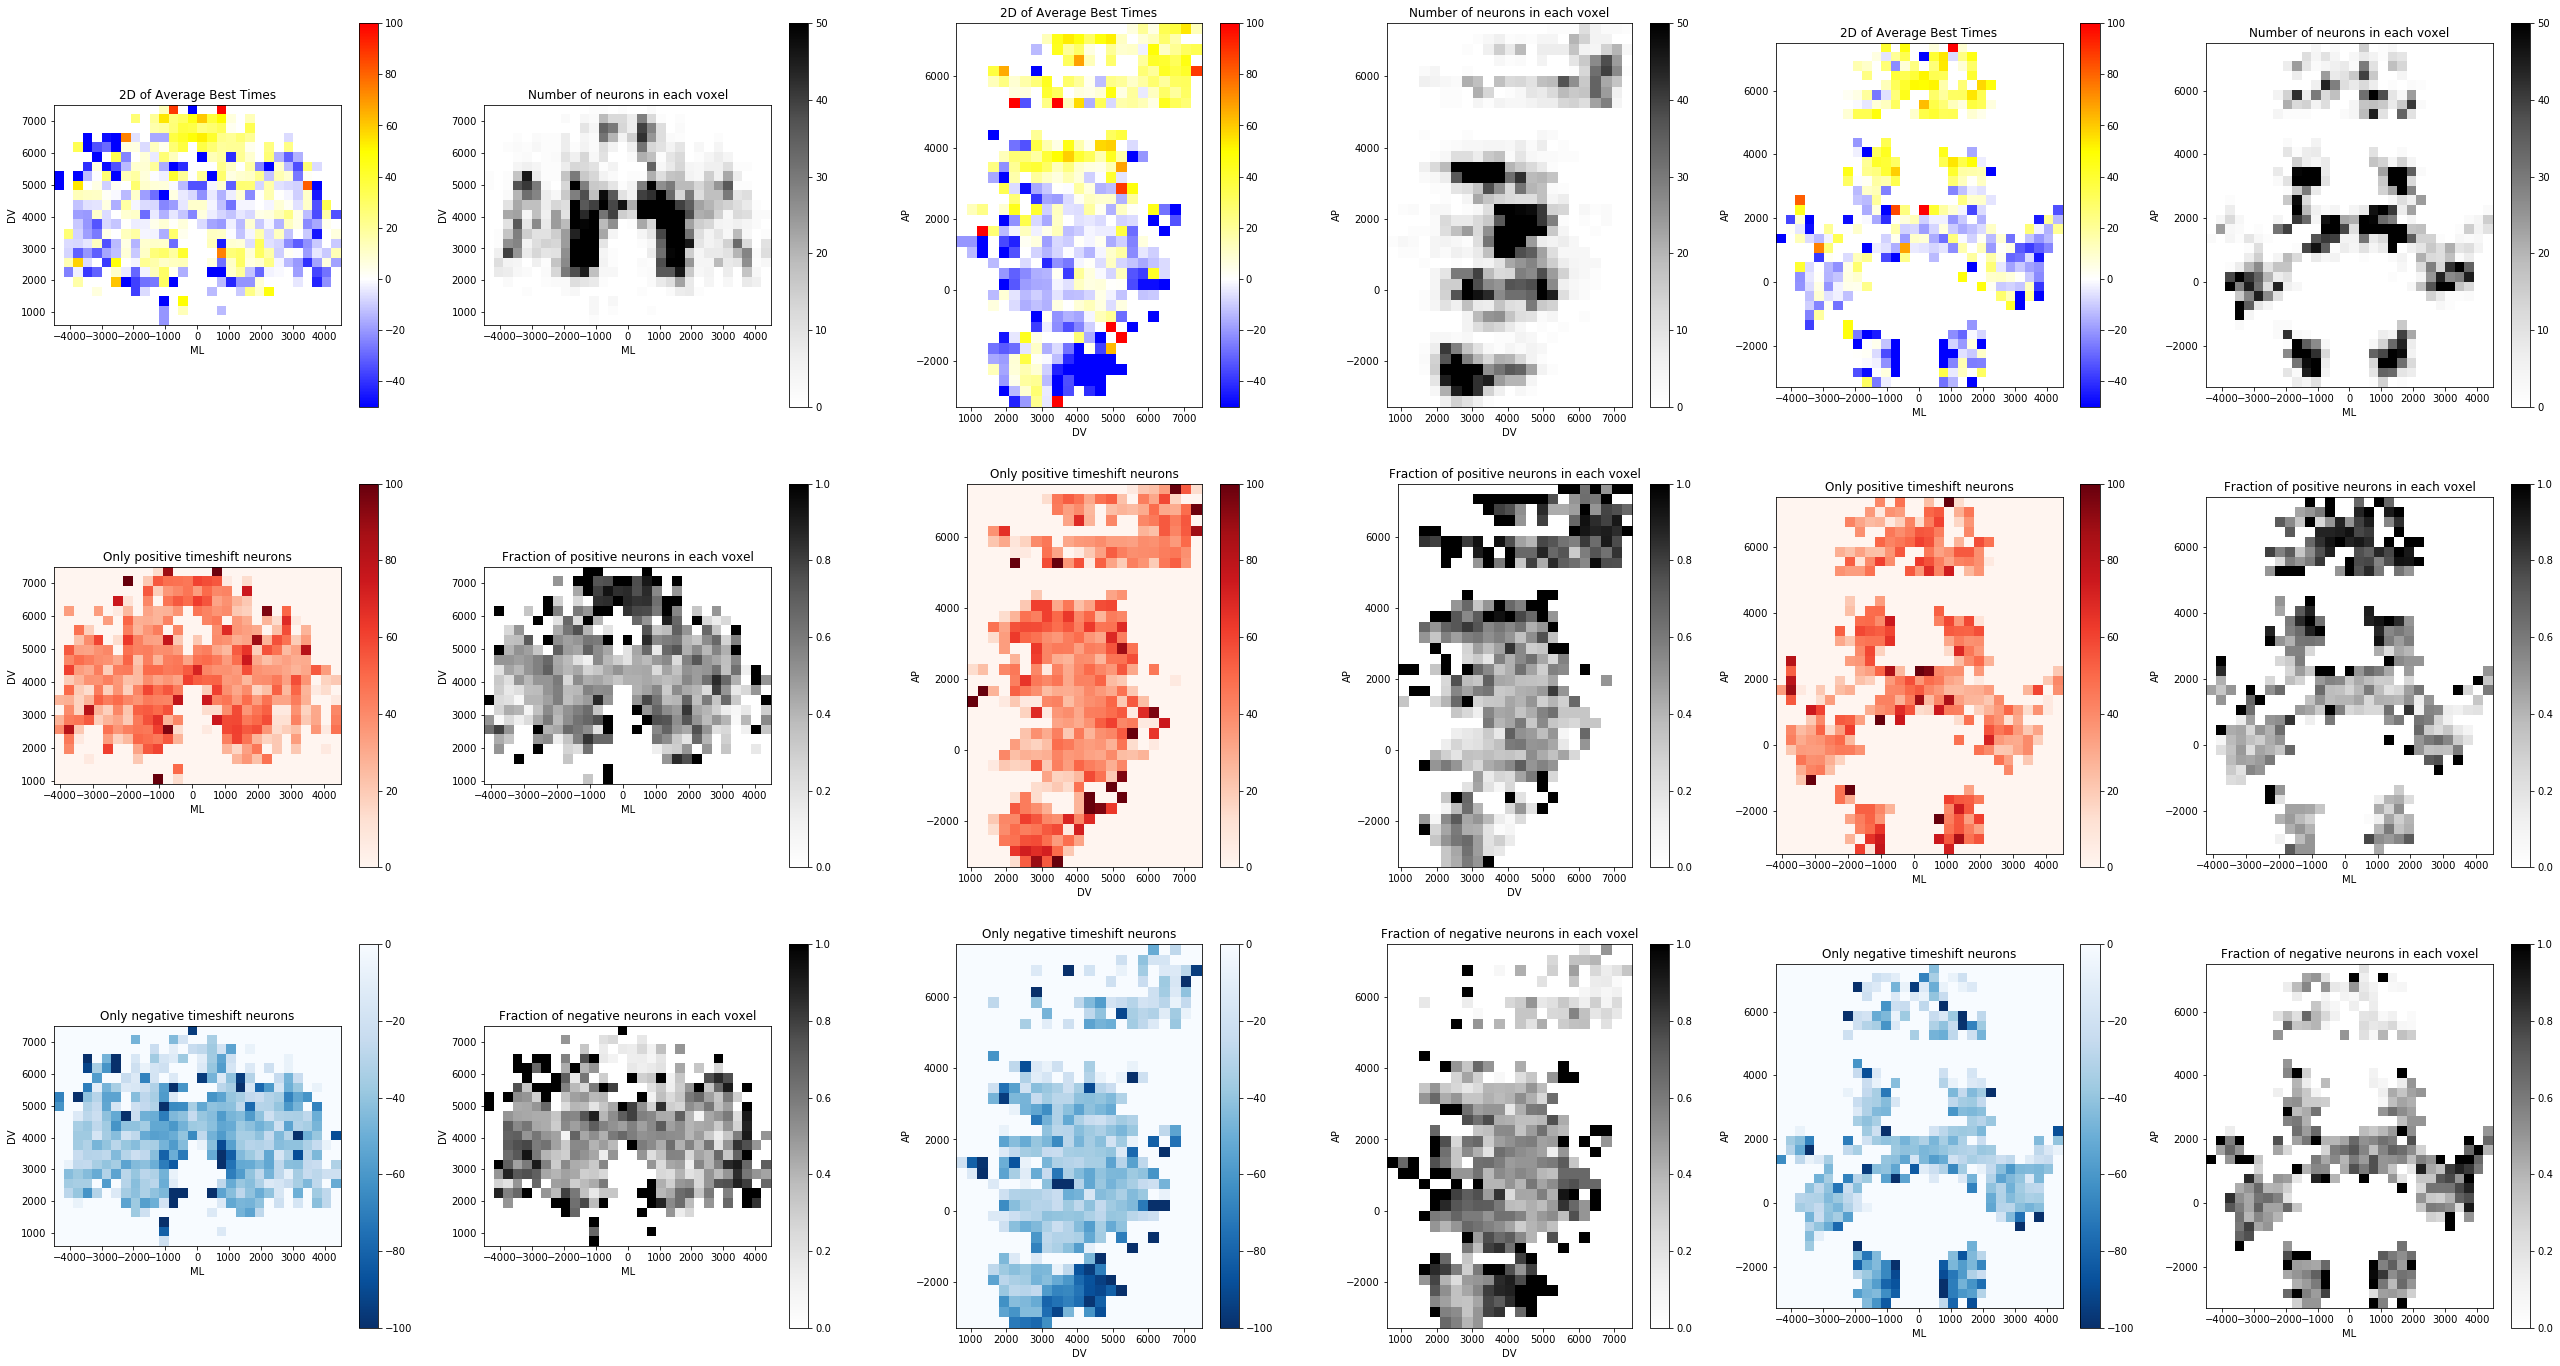

In [26]:
plt.subplots(3,6, figsize = (45,24))



# Define voxel size for the 2D plane
voxel_size = 300
avg_grid, min_indices_2, max_indices_2, grid_count_2 = get_2D_grid_averages_with_count(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 2)


plt.subplot(3,6,1)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices_2[0]*voxel_size, (max_indices_2[0]+1)*voxel_size, min_indices_2[1]*voxel_size, (max_indices_2[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D of Average Best Times')

plt.subplot(3,6,2)
plt.imshow(grid_count_2.T,origin='lower', cmap='Greys', vmin = 0,vmax = 50, extent=[min_indices_2[0]*voxel_size, (max_indices_2[0]+1)*voxel_size, min_indices_2[1]*voxel_size, (max_indices_2[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Number of neurons in each voxel')

avg_grid, min_indices_0, max_indices_0, grid_count_0 = get_2D_grid_averages_with_count(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 0)


plt.subplot(3,6,3)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices_0[0]*voxel_size, (max_indices_0[0]+1)*voxel_size, min_indices_0[1]*voxel_size, (max_indices_0[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

plt.subplot(3,6,4)
plt.imshow(grid_count_0.T,origin='lower', cmap='Greys', vmin = 0,vmax = 50, extent=[min_indices_0[0]*voxel_size, (max_indices_0[0]+1)*voxel_size, min_indices_0[1]*voxel_size, (max_indices_0[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Number of neurons in each voxel')

avg_grid, min_indices_1, max_indices_1, grid_count_1 = get_2D_grid_averages_with_count(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 1)


plt.subplot(3,6,5)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices_1[0]*voxel_size, (max_indices_1[0]+1)*voxel_size, min_indices_1[1]*voxel_size, (max_indices_1[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

plt.subplot(3,6,6)
plt.imshow(grid_count_1.T,origin='lower', cmap='Greys', vmin = 0,vmax = 50, extent=[min_indices_1[0]*voxel_size, (max_indices_1[0]+1)*voxel_size, min_indices_1[1]*voxel_size, (max_indices_1[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Number of neurons in each voxel')

pos_inds = np.where(best_times[restriction_inds] > 0)[0]

avg_grid, min_indices_2p, max_indices_2p,grid_count_2_p = get_2D_grid_averages_with_count(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 2)


plt.subplot(3,6,7)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices_2p[0]*voxel_size, (max_indices_2p[0]+1)*voxel_size, min_indices_2p[1]*voxel_size, (max_indices_2p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Only positive timeshift neurons')

plt.subplot(3,6,8)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_2_p, grid_count_2[min_indices_2p[0]-min_indices_2[0]:,min_indices_2p[1]-min_indices_2[1]:])
    frac_pos[np.isnan(avg_grid)] = 0
plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_2p[0]*voxel_size, (max_indices_2p[0]+1)*voxel_size, min_indices_2p[1]*voxel_size, (max_indices_2p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Fraction of positive neurons in each voxel')

avg_grid, min_indices_0p, max_indices_0p, grid_count_0_p = get_2D_grid_averages_with_count(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 0)


plt.subplot(3,6,9)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices_0p[0]*voxel_size, (max_indices_0p[0]+1)*voxel_size, min_indices_0p[1]*voxel_size, (max_indices_0p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Only positive timeshift neurons')

plt.subplot(3,6,10)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_0_p, grid_count_0[min_indices_0p[0]-min_indices_0[0]:,min_indices_0p[1]-min_indices_0[1]:])
    frac_pos[np.isnan(avg_grid)] = 0

plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_0p[0]*voxel_size, (max_indices_0p[0]+1)*voxel_size, min_indices_0p[1]*voxel_size, (max_indices_0p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Fraction of positive neurons in each voxel')

avg_grid, min_indices_1p, max_indices_1p, grid_count_1_p = get_2D_grid_averages_with_count(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 1)


plt.subplot(3,6,11)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices_1p[0]*voxel_size, (max_indices_1p[0]+1)*voxel_size, min_indices_1p[1]*voxel_size, (max_indices_1p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Only positive timeshift neurons')

plt.subplot(3,6,12)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_1_p, grid_count_1[min_indices_1p[0]-min_indices_1[0]:,min_indices_1p[1]-min_indices_1[1]:])
    frac_pos[np.isnan(avg_grid)] = 0

plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_1p[0]*voxel_size, (max_indices_1p[0]+1)*voxel_size, min_indices_1p[1]*voxel_size, (max_indices_1p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Fraction of positive neurons in each voxel')

neg_inds = np.where(best_times[restriction_inds] < 0)[0]
avg_grid, min_indices_2n, max_indices_2n, grid_count_2_n = get_2D_grid_averages_with_count(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 2)


plt.subplot(3,6,13)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices_2n[0]*voxel_size, (max_indices_2n[0]+1)*voxel_size, min_indices_2n[1]*voxel_size, (max_indices_2n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Only negative timeshift neurons')

plt.subplot(3,6,14)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_2_n, grid_count_2[min_indices_2n[0]-min_indices_2[0]:,min_indices_2n[1]-min_indices_2[1]:])
    frac_pos[np.isnan(avg_grid)] = 0

plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_2n[0]*voxel_size, (max_indices_2n[0]+1)*voxel_size, min_indices_2n[1]*voxel_size, (max_indices_2n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Fraction of negative neurons in each voxel')

avg_grid, min_indices_0n, max_indices_0n, grid_count_0_n = get_2D_grid_averages_with_count(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 0)


plt.subplot(3,6,15)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices_0n[0]*voxel_size, (max_indices_0n[0]+1)*voxel_size, min_indices_0n[1]*voxel_size, (max_indices_0n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Only negative timeshift neurons')

plt.subplot(3,6,16)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_0_n, grid_count_0[min_indices_0n[0]-min_indices_0[0]:,min_indices_0n[1]-min_indices_0[1]:])
    frac_pos[np.isnan(avg_grid)] = 0
plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_0n[0]*voxel_size, (max_indices_0n[0]+1)*voxel_size, min_indices_0n[1]*voxel_size, (max_indices_0n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Fraction of negative neurons in each voxel')

avg_grid, min_indices_1n, max_indices_1n,grid_count_1_n = get_2D_grid_averages_with_count(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 1)


plt.subplot(3,6,17)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices_1n[0]*voxel_size, (max_indices_1n[0]+1)*voxel_size, min_indices_1n[1]*voxel_size, (max_indices_1n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Only negative timeshift neurons')

plt.subplot(3,6,18)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_1_n, grid_count_1[min_indices_1n[0]-min_indices_1[0]:,min_indices_1n[1]-min_indices_1[1]:])
    frac_pos[np.isnan(avg_grid)] = 0
plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_1n[0]*voxel_size, (max_indices_1n[0]+1)*voxel_size, min_indices_1n[1]*voxel_size, (max_indices_1n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Fraction of negative neurons in each voxel')

plt.savefig(figfolder + 'best_times_spatial_distributions_all_pos_neg_with_fraction.pdf', bbox_inches='tight')


In [18]:
max_indices_2

array([14, 24])

In [19]:
max_indices_2p

array([14, 24])

In [21]:
print(min_indices_2)
print(min_indices_2p)

[-15   2]
[-14   3]


In [80]:
big_areas = [
    'Medulla',
    'Midbrain',
    'ALM',
    'Striatum',
    'Thalamus'
]

area_colors = ['b', 'k', 'g', 'c', 'y']

big_area_inds = get_inds_for_list_of_regions(big_areas,df,ccf_labels,alm_inds)

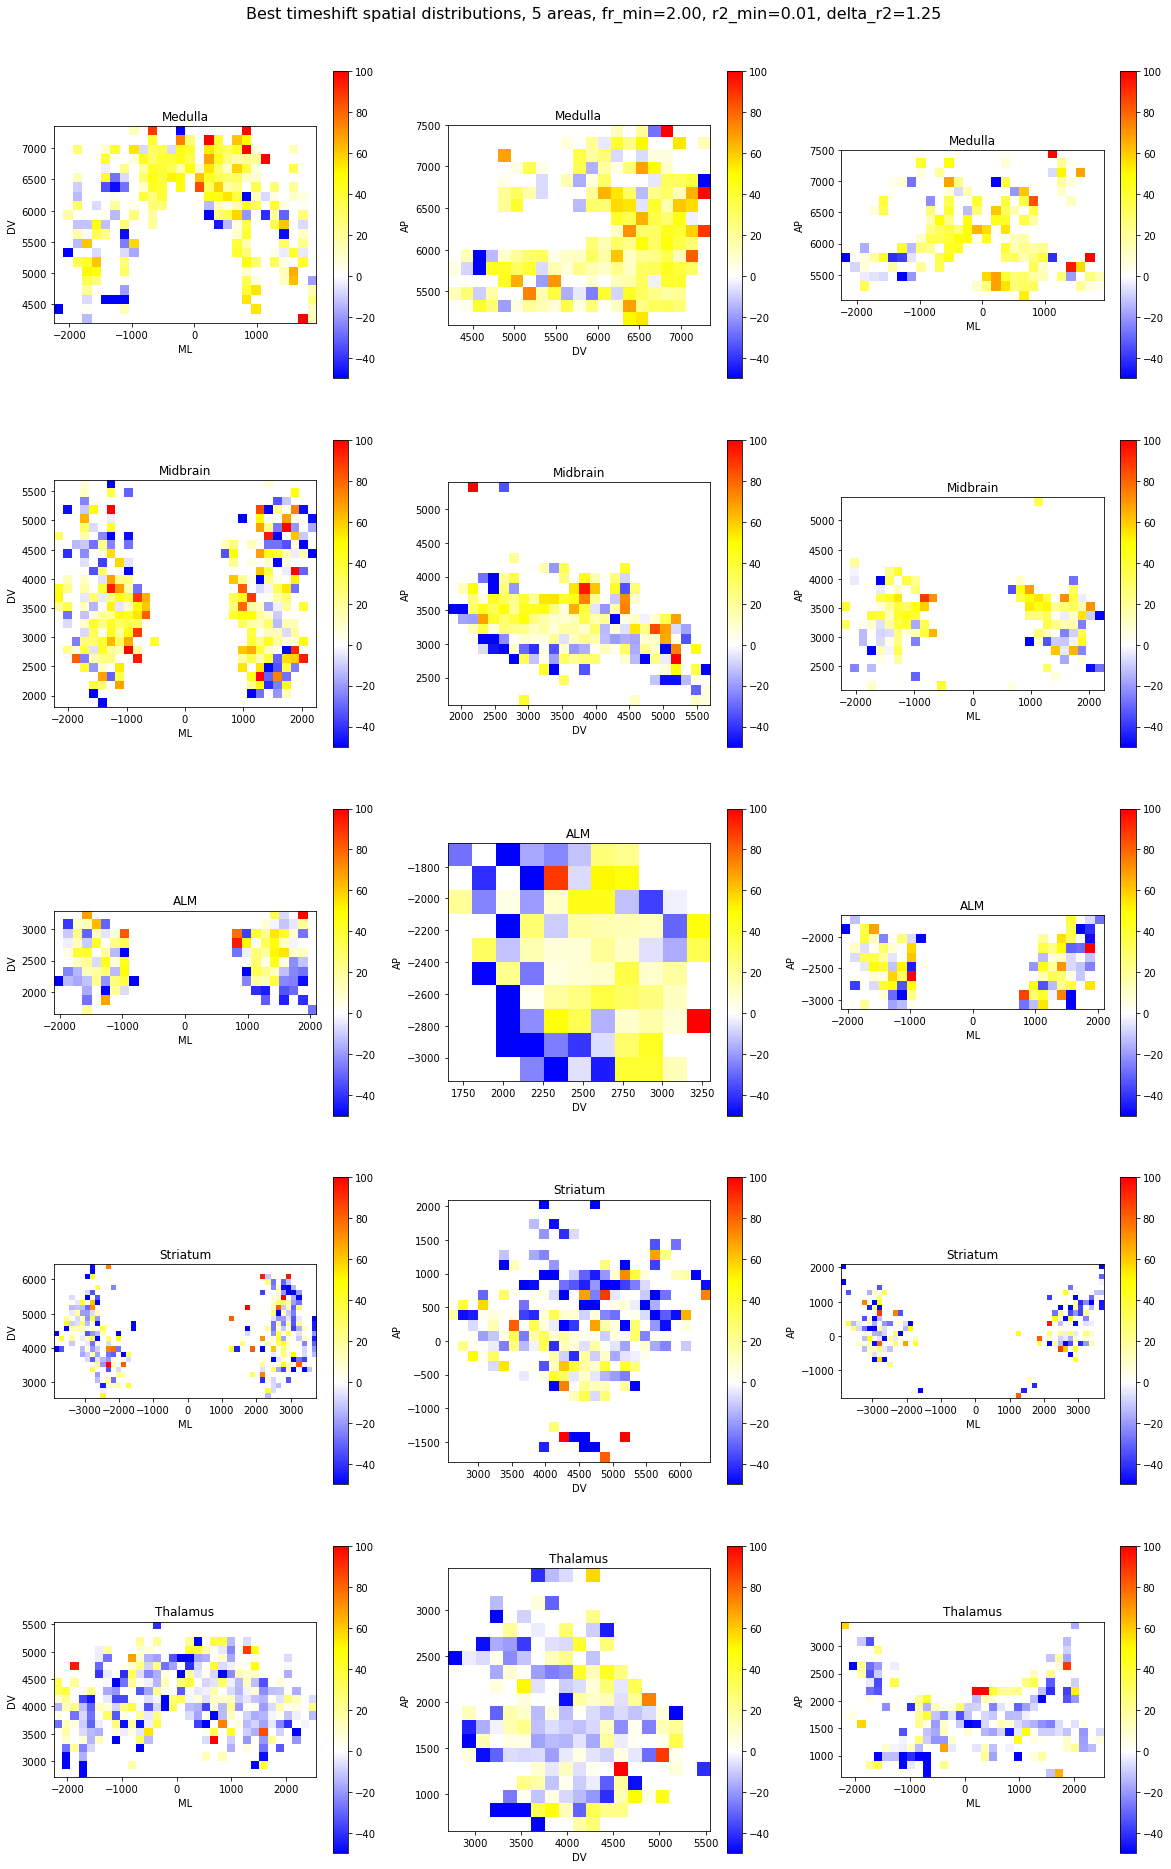

In [86]:
f,_ = plt.subplots(5,3, figsize = (20,30))
f.suptitle('Best timeshift spatial distributions, 5 areas, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(fr_threshold,r2_threshold,delta_r2), fontsize = 16)

voxel_size = 150

for i, area in enumerate(big_areas):
    _this_area_inds = big_area_inds[area]
    _this_inds = np.intersect1d(restriction_inds,_this_area_inds)

    avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[_this_inds], ccf_coords[_this_inds], voxel_size, projection_axis = 2)


    plt.subplot(5,3,3*i+1)
    plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
    plt.colorbar()
    plt.xlabel('ML')
    plt.ylabel('DV')
    plt.title(area)

    avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[_this_inds], ccf_coords[_this_inds], voxel_size, projection_axis = 0)


    plt.subplot(5,3,3*i+2)
    plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
    plt.colorbar()
    plt.xlabel('DV')
    plt.ylabel('AP')
    plt.title(area)

    avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[_this_inds], ccf_coords[_this_inds], voxel_size, projection_axis = 1)


    plt.subplot(5,3,3*i+3)
    plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
    plt.colorbar()
    plt.xlabel('ML')
    plt.ylabel('AP')
    plt.title(area)

plt.subplots_adjust(top = 0.95)
plt.savefig(figfolder + 'Best_timeshift_spatial_distributions_bigregions.pdf',bbox_inches = 'tight')

In [90]:
def gaussian_kernel(distance, bandwidth):
    """
    Gaussian kernel function.
    """
    return (1 / (bandwidth * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (distance / bandwidth) ** 2)

def smooth_curve(coords, values, bandwidth, resolution=1000):
    """
    Smooth and locally average a curve based on coordinates, values, and bandwidth.
    
    :param coords: Array of coordinates (1D).
    :param values: Array of values corresponding to each coordinate.
    :param bandwidth: Bandwidth λ for the smoothing kernel.
    :param resolution: Number of points in the smoothed curve.
    :return: Tuple of smoothed_coords, smoothed_values.
    """
    # Generate smoothed curve coordinates with specified resolution
    smoothed_coords = np.linspace(np.min(coords), np.max(coords), resolution)
    
    # Initialize array for smoothed values
    smoothed_values = np.zeros_like(smoothed_coords)
    
    # Apply the Nadaraya-Watson kernel regression
    for i, coord in enumerate(smoothed_coords):
        # Calculate distances from current coord to all other coords
        distances = np.abs(coords - coord)
        
        # Calculate weights using the Gaussian kernel
        weights = gaussian_kernel(distances, bandwidth)
        
        # Calculate weighted average
        smoothed_values[i] = np.sum(weights * values) / np.sum(weights)
    
    return smoothed_coords, smoothed_values



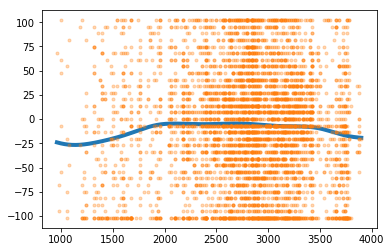

In [96]:
ll = 200
smooth_ml, smooth_values = smooth_curve(np.abs(ccf_coords[big_area_inds['Striatum']][:,0]), best_times[big_area_inds['Striatum']],ll)
plt.plot(smooth_ml,smooth_values, lw = 4)
plt.plot(np.abs(ccf_coords[big_area_inds['Striatum']][:,0]), best_times[big_area_inds['Striatum']],'.',alpha = 0.3)

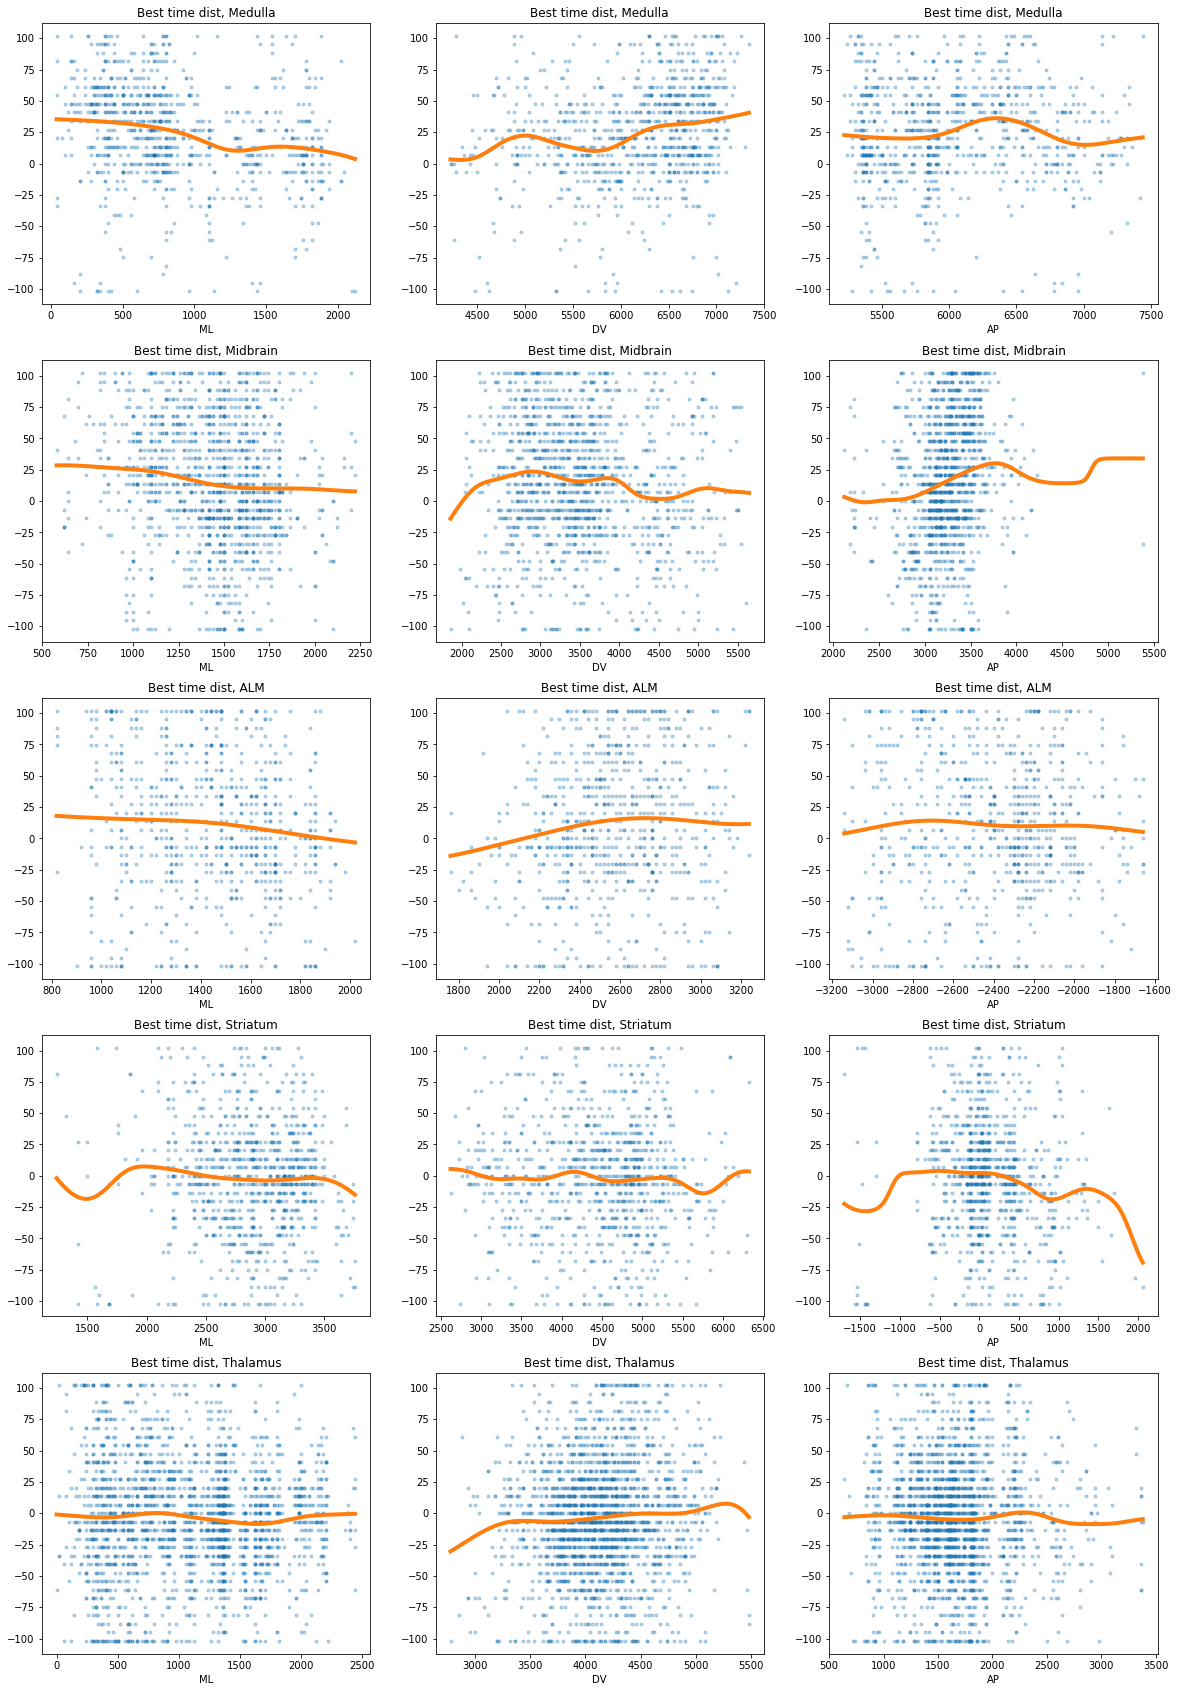

In [103]:
plt.subplots(5,3,figsize = (20,30))

for i, area in enumerate(big_areas):
    _this_area_inds = big_area_inds[area]
    _this_inds = np.intersect1d(restriction_inds,_this_area_inds)

    plt.subplot(5,3,3*i+1)
    plt.title('Best time dist, %s'%area)
    plt.plot(np.abs(ccf_coords[_this_inds][:,0]), best_times[_this_inds],'.',alpha = 0.3)
    smooth_coords, smooth_values = smooth_curve(np.abs(ccf_coords[_this_inds][:,0]), best_times[_this_inds],ll)
    plt.plot(smooth_coords,smooth_values, lw = 4)
    plt.xlabel('ML')

    plt.subplot(5,3,3*i+2)
    plt.title('Best time dist, %s'%area)
    plt.plot(ccf_coords[_this_inds][:,1], best_times[_this_inds],'.',alpha = 0.3)
    smooth_coords, smooth_values = smooth_curve(ccf_coords[_this_inds][:,1], best_times[_this_inds],ll)
    plt.plot(smooth_coords,smooth_values, lw = 4)
    plt.xlabel('DV')

    plt.subplot(5,3,3*i+3)
    plt.title('Best time dist, %s'%area)
    plt.plot(ccf_coords[_this_inds][:,2], best_times[_this_inds],'.',alpha = 0.3)
    smooth_coords, smooth_values = smooth_curve(ccf_coords[_this_inds][:,2], best_times[_this_inds],ll)
    plt.plot(smooth_coords,smooth_values, lw = 4)
    plt.xlabel('AP')

plt.savefig(figfolder + 'Best_timeshift_spatial_distributions_bigregions_smoothed_1d.pdf',bbox_inches = 'tight')

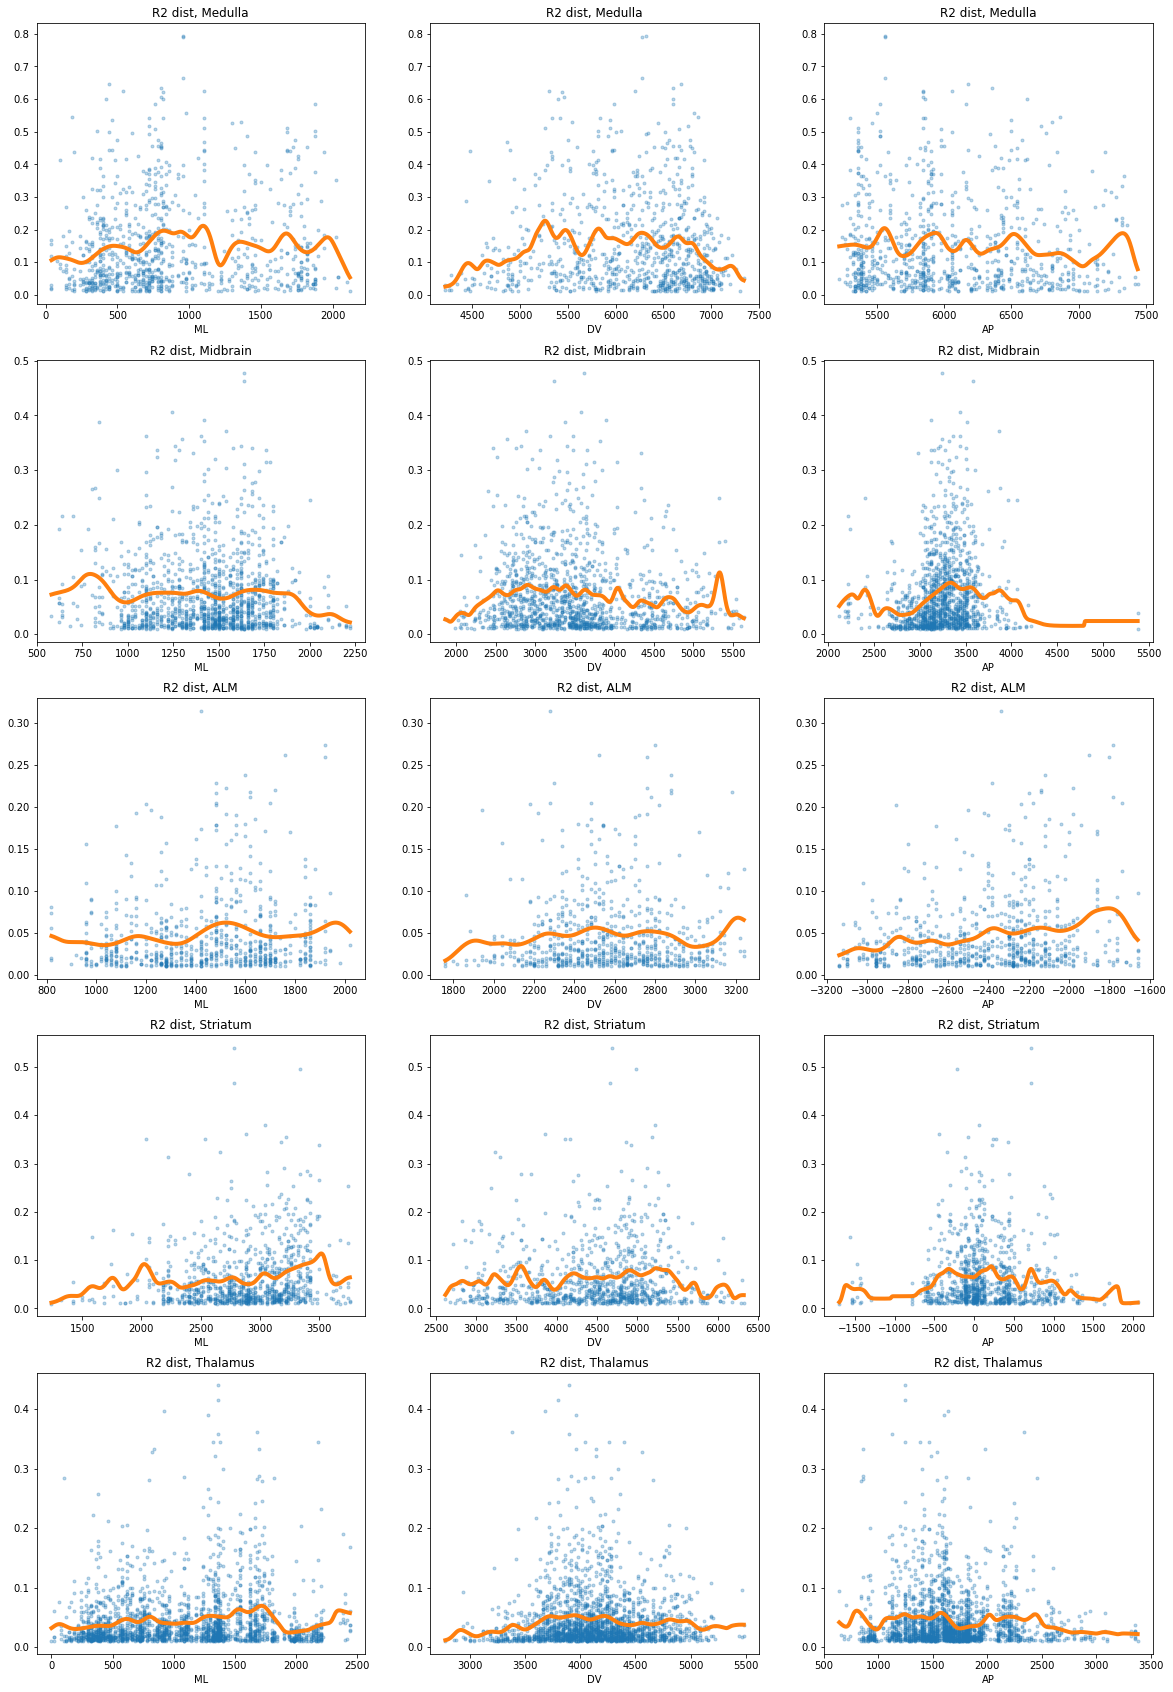

In [105]:
plt.subplots(5,3,figsize = (20,30))

_this_r2 = r2_new['5_0']['%s_r2%s'%(epoch,method_to_string[r2_method])].copy()
ll = 50
for i, area in enumerate(big_areas):
    _this_area_inds = big_area_inds[area]
    _this_inds = np.intersect1d(restriction_inds,_this_area_inds)

    plt.subplot(5,3,3*i+1)
    plt.title('R2 dist, %s'%area)
    plt.plot(np.abs(ccf_coords[_this_inds][:,0]), _this_r2[_this_inds],'.',alpha = 0.3)
    smooth_coords, smooth_values = smooth_curve(np.abs(ccf_coords[_this_inds][:,0]),_this_r2[_this_inds],ll)
    plt.plot(smooth_coords,smooth_values, lw = 4)
    plt.xlabel('ML')

    plt.subplot(5,3,3*i+2)
    plt.title('R2 dist, %s'%area)
    plt.plot(ccf_coords[_this_inds][:,1], _this_r2[_this_inds],'.',alpha = 0.3)
    smooth_coords, smooth_values = smooth_curve(ccf_coords[_this_inds][:,1],_this_r2[_this_inds],ll)
    plt.plot(smooth_coords,smooth_values, lw = 4)
    plt.xlabel('DV')

    plt.subplot(5,3,3*i+3)
    plt.title('R2 dist, %s'%area)
    plt.plot(ccf_coords[_this_inds][:,2], _this_r2[_this_inds],'.',alpha = 0.3)
    smooth_coords, smooth_values = smooth_curve(ccf_coords[_this_inds][:,2], _this_r2[_this_inds],ll)
    plt.plot(smooth_coords,smooth_values, lw = 4)
    plt.xlabel('AP')

plt.savefig(figfolder + 'R2_spatial_distributions_bigregions_smoothed_1d.pdf',bbox_inches = 'tight')

In [29]:
r2_threshold = .02
fr_threshold = 4.

epoch = 'response'
r2_method = 'new'
timewindow_cut = 'fixed_small'

fr = r2_new['5_0']['avg_fr'].copy()
r2 = []

for timesh in timeshifts:
    r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

r2 = np.array(r2)
# there are no negative values in the new method
#r2[r2<0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)

best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]

In [35]:

inds = get_inds_for_list_of_regions(use_midbrain_list, df, ccf_labels)
use_inds = {k: v for k,v in inds.items() if v.shape[0] > 100}

<ipython-input-36-3749559f48f0>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


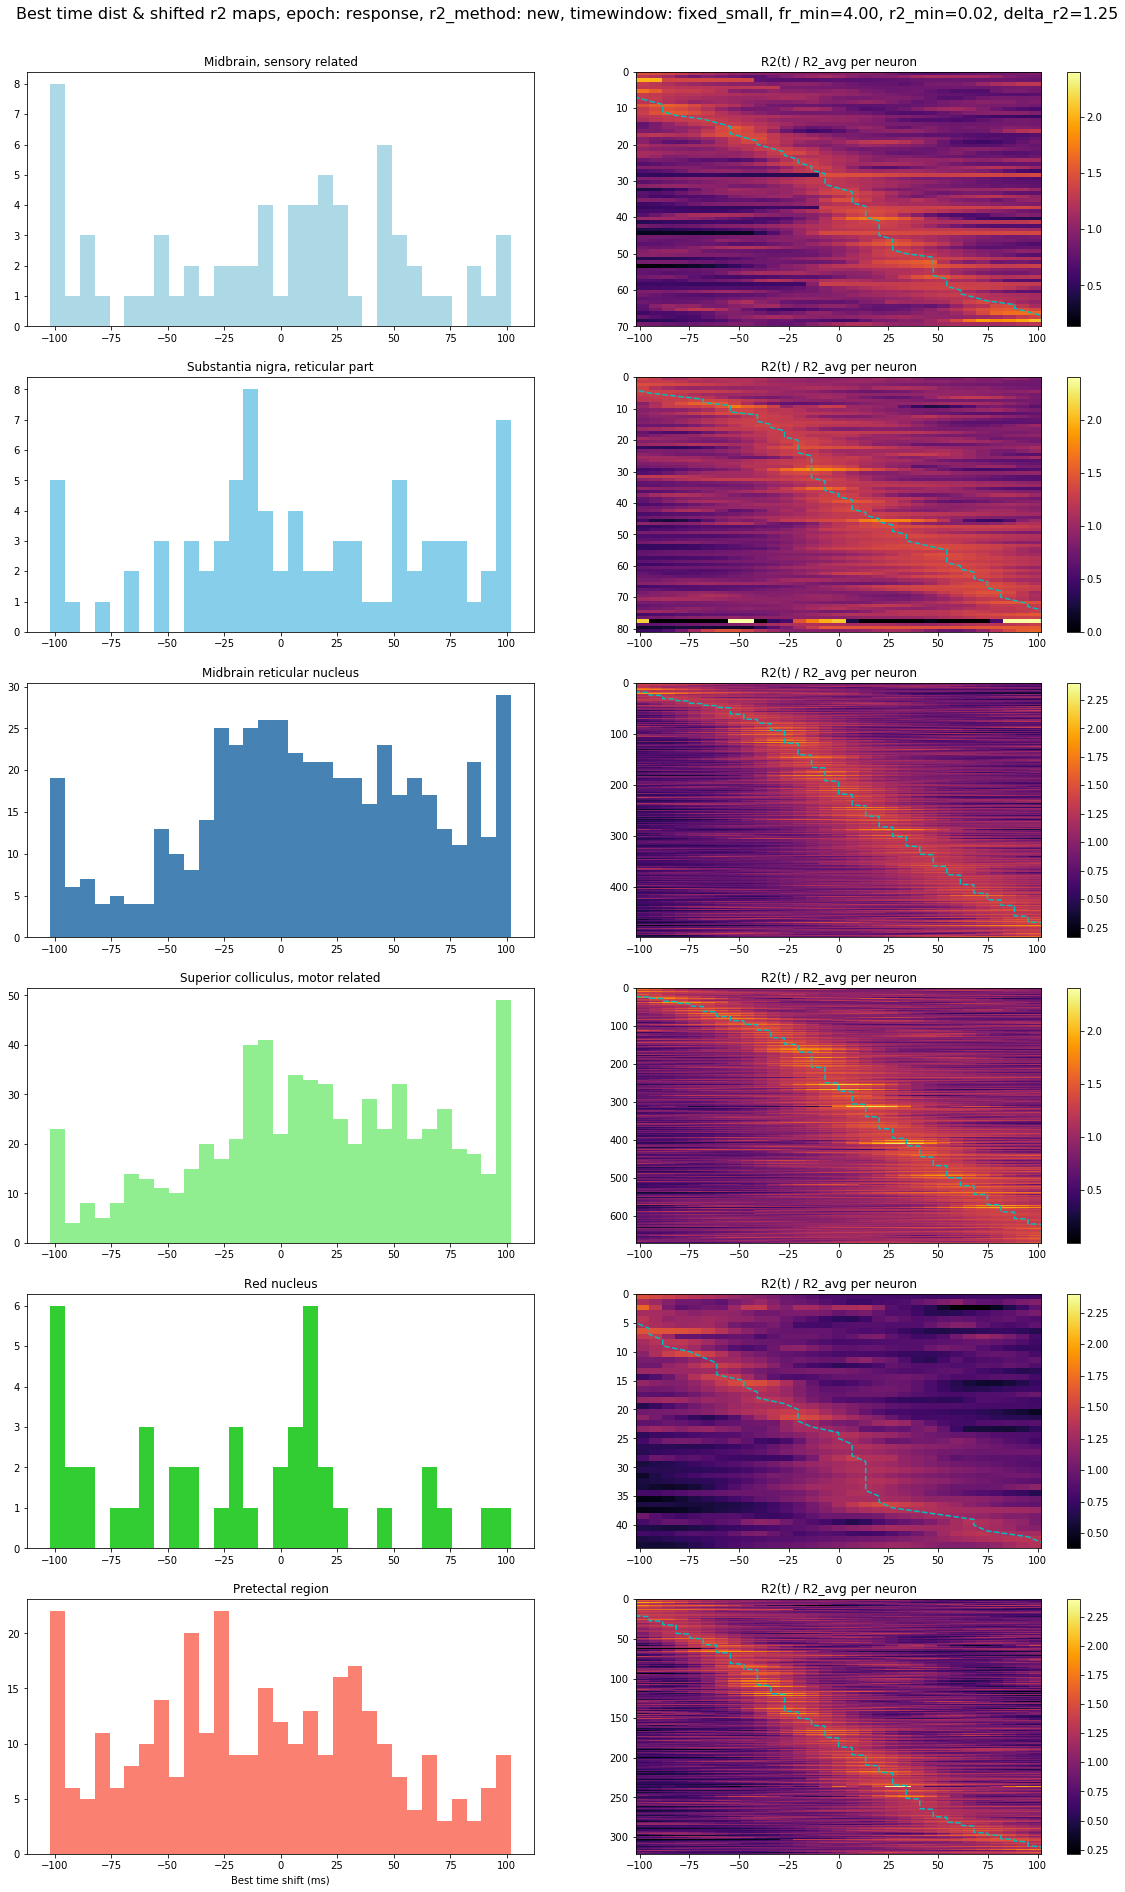

In [36]:
delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    plt.title(area)
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto',vmax = 2.4, cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
#plt.savefig(figfolder + 'max_over_avg_filtering_scan_best_time_dist_and_r2_maps.pdf', bbox_inches = 'tight')

In [38]:
use_cortex_list = ['Somatosensory areas',
                   'Somatomotor areas',
                   'Auditory areas',
                   'Orbital area',
                   'Agranular insular area',
                   'Retrosplenial area',]

col_list = [
    "lightblue",    # Some kind of blue
    "skyblue",      # Some kind of blue
    "steelblue",    # Some kind of blue
    "lightgreen",   # Some kind of green
    "limegreen",    # Some kind of green
    "salmon",
    "tomato",
    "coral"
]

In [39]:

inds = get_inds_for_list_of_regions(use_cortex_list, df, ccf_labels)
use_inds = {k: v for k,v in inds.items() if v.shape[0] > 100}

<ipython-input-40-3749559f48f0>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


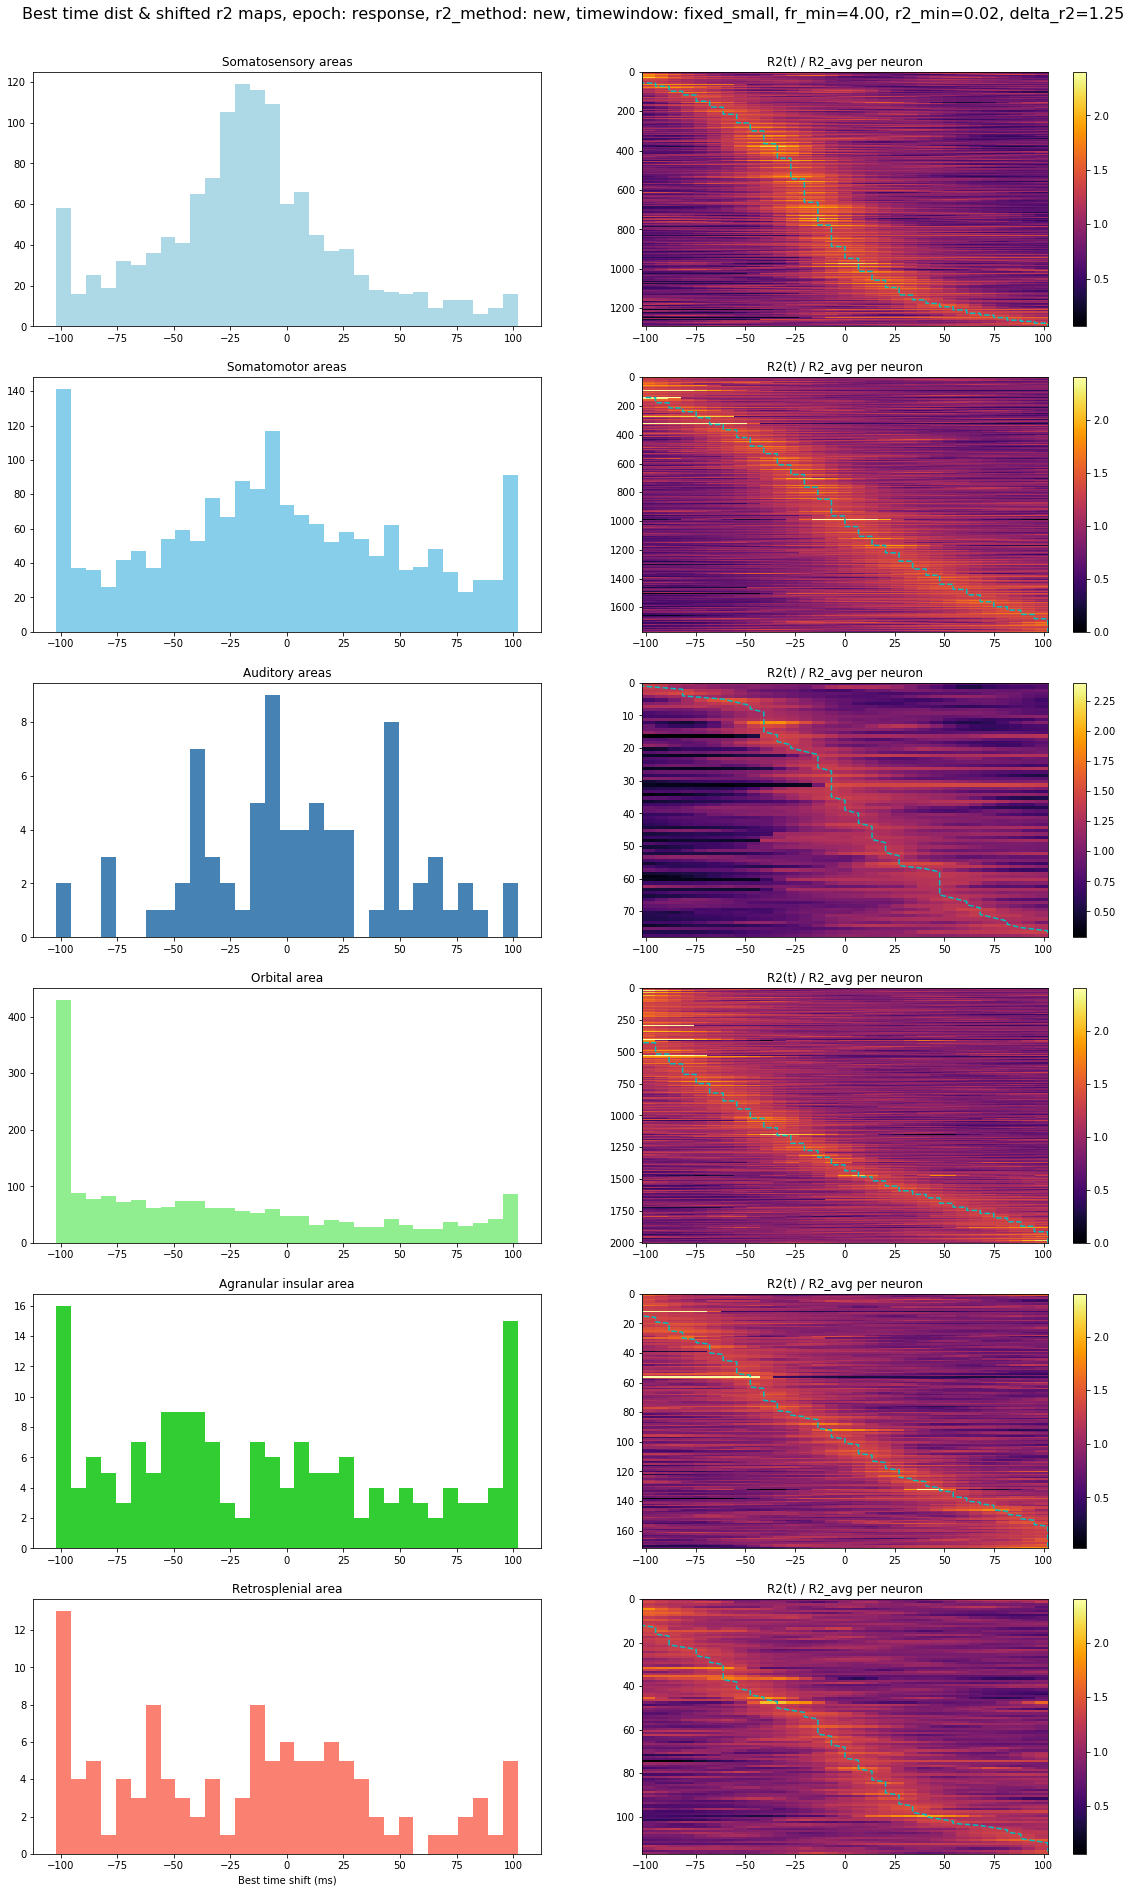

In [40]:
delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    plt.title(area)
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto',vmax = 2.4, cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
#plt.savefig(figfolder + 'max_over_avg_filtering_scan_best_time_dist_and_r2_maps.pdf', bbox_inches = 'tight')

/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


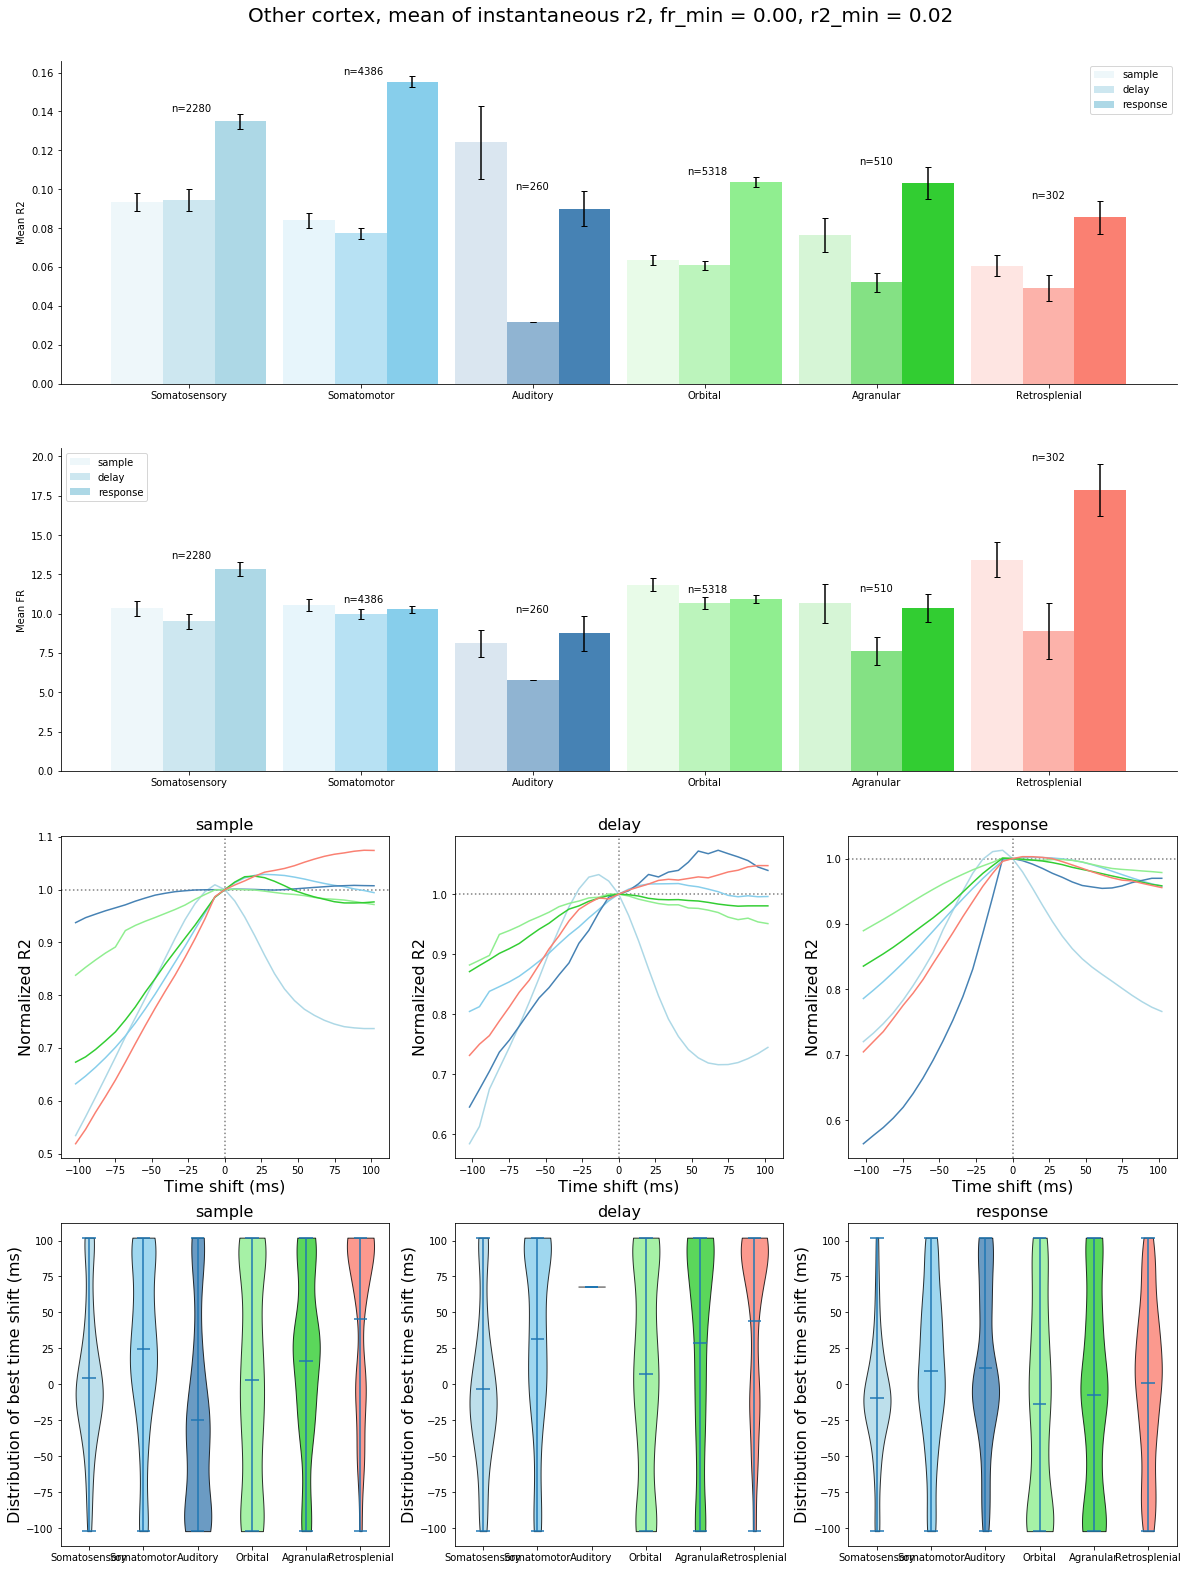

In [9]:
create_summary_plot(use_cortex_list, col_list, r2_new, timeshifts, epochs, r2_method = 'old_clipped', axis_names = [a.split(' ')[0] for a in use_cortex_list], titlestr = 'Other cortex, mean of instantaneous r2', method_to_string = method_to_string, r2_threshold=0.02, fr_threshold=0)
plt.savefig(figfolder + 'cortex_r2_summary.png', bbox_inches = 'tight')

In [10]:
use_midbrain_list = [
    'Midbrain, sensory related',
    'Substantia nigra, reticular part',
    'Midbrain reticular nucleus',
    'Superior colliculus, motor related',
    #'Periaqueductal gray',
    #'Cuneiform nucleus',
    'Red nucleus',
    'Pretectal region',
    'Substantia nigra, compact part',
    'Pedunculopontine nucleus',
]

short_midbrain_names = [
    'Sensory',
    'SNR',
    'Reticular',
    'SCM',
    #'PG',
    'Red',
    'Pretectal',
    'SNC',
    'Pendunculopontine'

]

color_list = [
    "gray",
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",
    "red",
    "coral"
]

/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


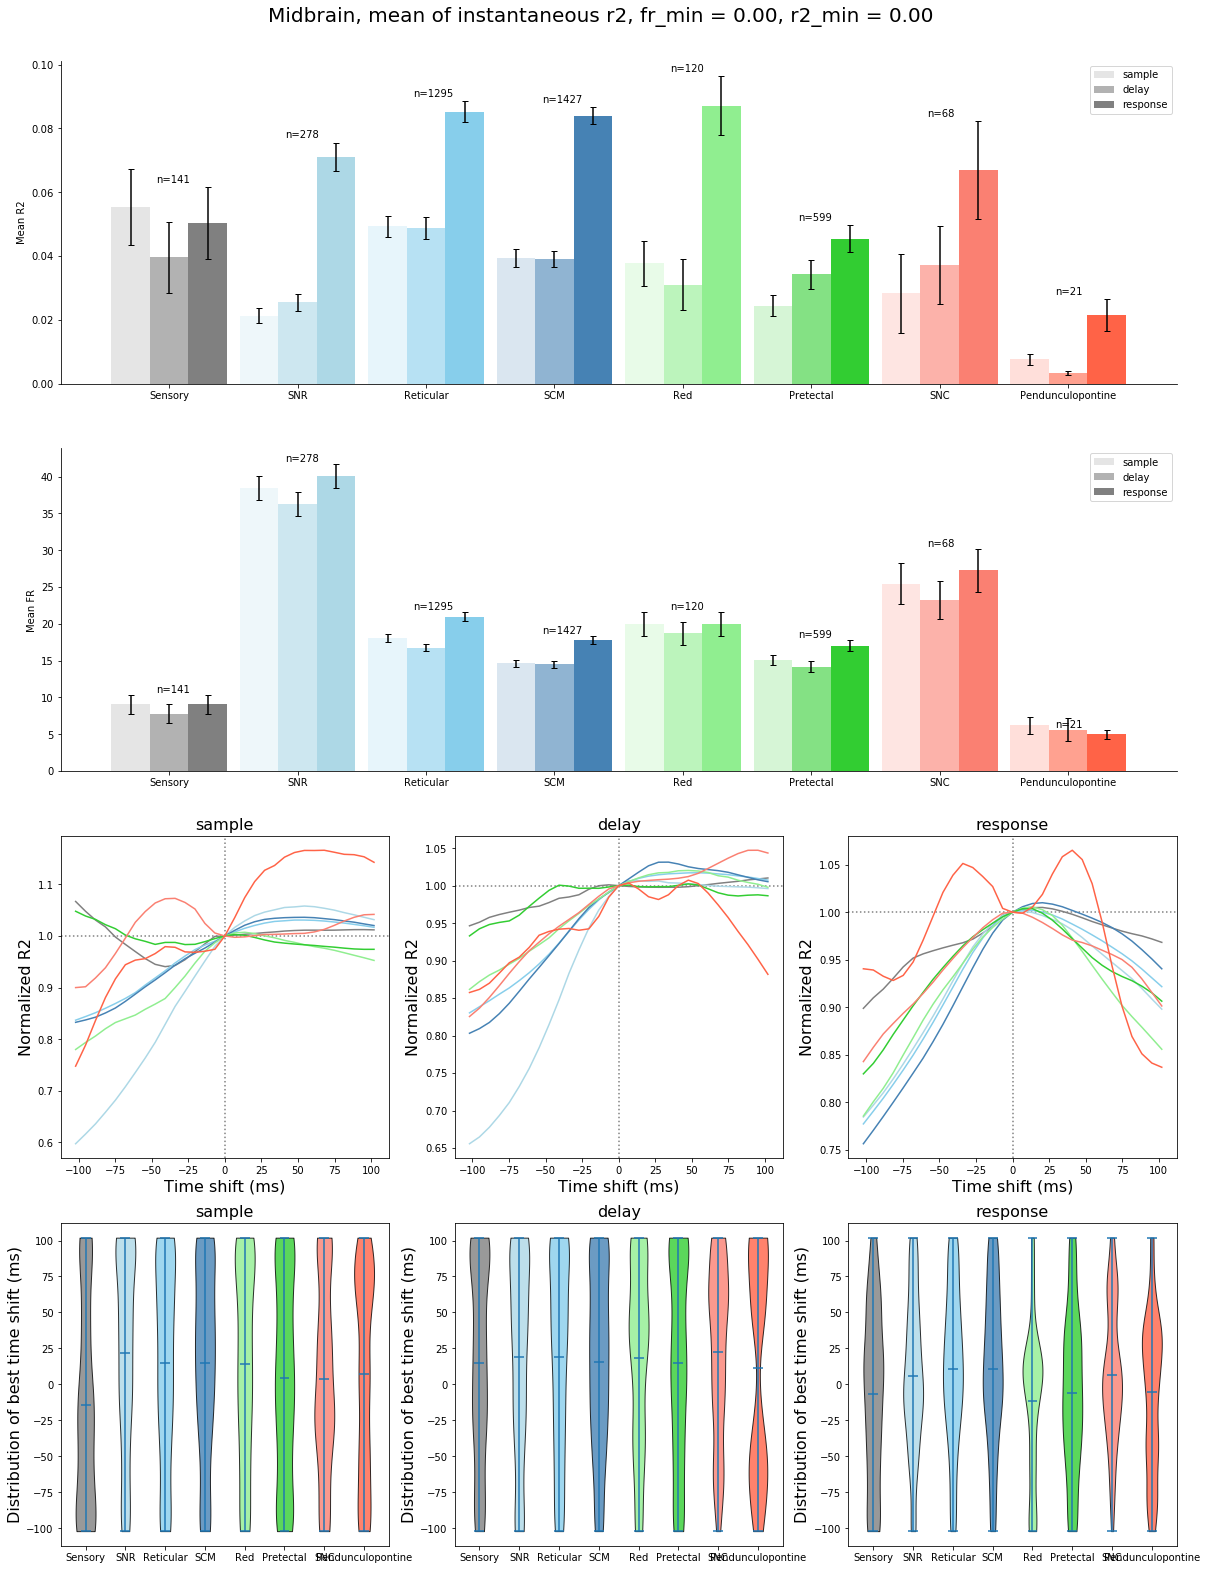

In [34]:
create_summary_plot(use_midbrain_list, color_list, r2_new, timeshifts, epochs, r2_method = 'new', axis_names = short_midbrain_names,titlestr = 'Midbrain, mean of instantaneous r2', method_to_string = method_to_string, fr_threshold=0.0, r2_threshold=0.0)
#plt.savefig(figfolder + 'midbrain_summary_plot.png', dpi = 300)

In [172]:
thalamus_subregions_annotation_dict = dict()

for subreg in thalamus_use_nuclei:
    thalamus_subregions_annotation_dict[subreg] = func.get_all_subregion_annotations_from_name(df, subreg)['region'].values

print(thalamus_subregions_annotation_dict)

{'Anteromedial nucleus': array(['Anteromedial nucleus', 'Anteromedial nucleus, dorsal part',
       'Anteromedial nucleus, ventral part'], dtype=object), 'Central medial nucleus of the thalamus': array(['Central medial nucleus of the thalamus'], dtype=object), 'Mediodorsal nucleus of thalamus': array(['Mediodorsal nucleus of thalamus',
       'Mediodorsal nucleus of the thalamus, central part',
       'Mediodorsal nucleus of the thalamus, lateral part',
       'Mediodorsal nucleus of the thalamus, medial part'], dtype=object), 'Medial geniculate complex': array(['Medial geniculate complex',
       'Medial geniculate complex, dorsal part',
       'Medial geniculate complex, ventral part',
       'Medial geniculate complex, medial part'], dtype=object), 'Paracentral nucleus': array(['Paracentral nucleus'], dtype=object), 'Parafascicular nucleus': array(['Parafascicular nucleus'], dtype=object), 'Posterior complex of the thalamus': array(['Posterior complex of the thalamus'], dtype=object

In [23]:
inds = func.get_neuron_inds_for_subregions(ccf_labels, thalamus_subregions_annotation_dict)

n_neurons = [v.shape[0] for v in inds.values()]
n_neurons

[97, 197, 1646, 138, 407, 179, 704, 21, 77, 160, 643, 320, 524]

In [24]:
timeshifts = [-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16]

timeshifts = np.array(timeshifts)

<ipython-input-40-0865f52cf7f5>:90: RuntimeWarning: Mean of empty slice.
  avg_r2 = r2[:,this_inds].mean(axis = 1)
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


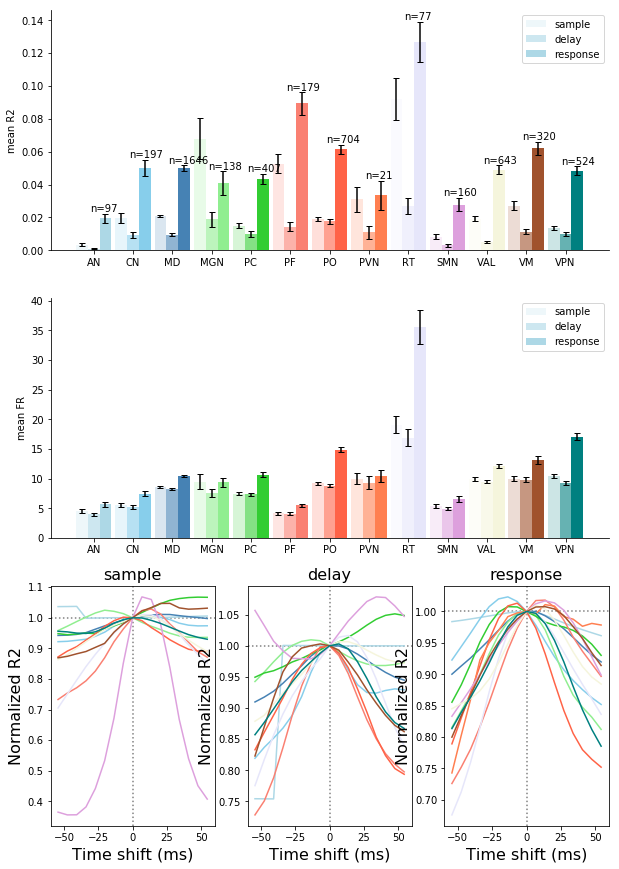

In [40]:
f = plt.figure(figsize=(10,15))
cc = ['grey','blue','green']
cc = [
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",     # A bright red-orange
    "coral",      # A soft, pinkish-orange
    "lavender",   # A soft, light purple
    "plum",       # A dark, rich purple
    "beige",      # A soft, pale sandy color
    "sienna",     # A reddish-brown earth tone
    "teal"        # A medium blue-green color
]

epoch_ls = ['solid','solid','solid']

ax_bar = f.add_subplot(3,1,1)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(r2, inds, thalamus_use_nuclei)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 0.2 + iepoch*0.4, color = cc, 
                capsize = 3, width=0.3, label = epoch)
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, m[i] + sem[i] + 0.1 * max(sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(short_names, rotation = 0)
_ = ax_bar.set_ylabel('mean R2')

ax_bar = f.add_subplot(3,1,2)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m_fr, sem_fr = func.get_mean_and_sem_for_subregions(fr, inds, thalamus_use_nuclei)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m_fr, yerr = sem_fr, alpha = 0.2 + iepoch*0.4, color = cc, 
                capsize = 3, width=0.3, label = epoch)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(short_names, rotation = 0)
_ = ax_bar.set_ylabel('mean FR')

#ax_ts = f.add_subplot(3,1,3)

r2_threshold = .02
fr_threshold = 0.

for iepoch, epoch in enumerate(epochs):
    ax_ts = f.add_subplot(3,3,7 + iepoch)

    r2 = []

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2'%epoch].copy())

    r2= np.array(r2)
    r2[r2<0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[8,:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)



    ax_ts.set_title('%s'%(epoch), fontsize = 16)
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]

        this_inds = np.intersect1d(this_inds, threshold_inds)
        avg_r2 = r2[:,this_inds].mean(axis = 1)

        ax_ts.plot(timeshifts*3.4, avg_r2/avg_r2[8],color = cc[j], ls= epoch_ls[iepoch], label = area + ', ' + epoch)

    a,b = ax_ts.set_xlim()
    ax_ts.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    ax_ts.set_xlim(a,b)

    a,b = ax_ts.set_ylim()
    ax_ts.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    ax_ts.set_ylim(a,b)

    ax_ts.set_xlabel('Time shift (ms)', fontsize = 16)
    ax_ts.set_ylabel('Normalized R2', fontsize = 16)
#ax_ts.legend()

#plt.savefig(figfolder + 'normalized_r2_timeshifts_r2_fr_threshold.png', dpi = 300)

plt.savefig(figfolder + 'thalamus_subregions_1layer_fr_r2_%s_new.png'%epoch)
plt.show()
plt.close()

<ipython-input-39-6e458c1754b7>:90: RuntimeWarning: Mean of empty slice.
  avg_r2 = r2[:,this_inds].mean(axis = 1)
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/kurgyis/.local/lib/python3.8/

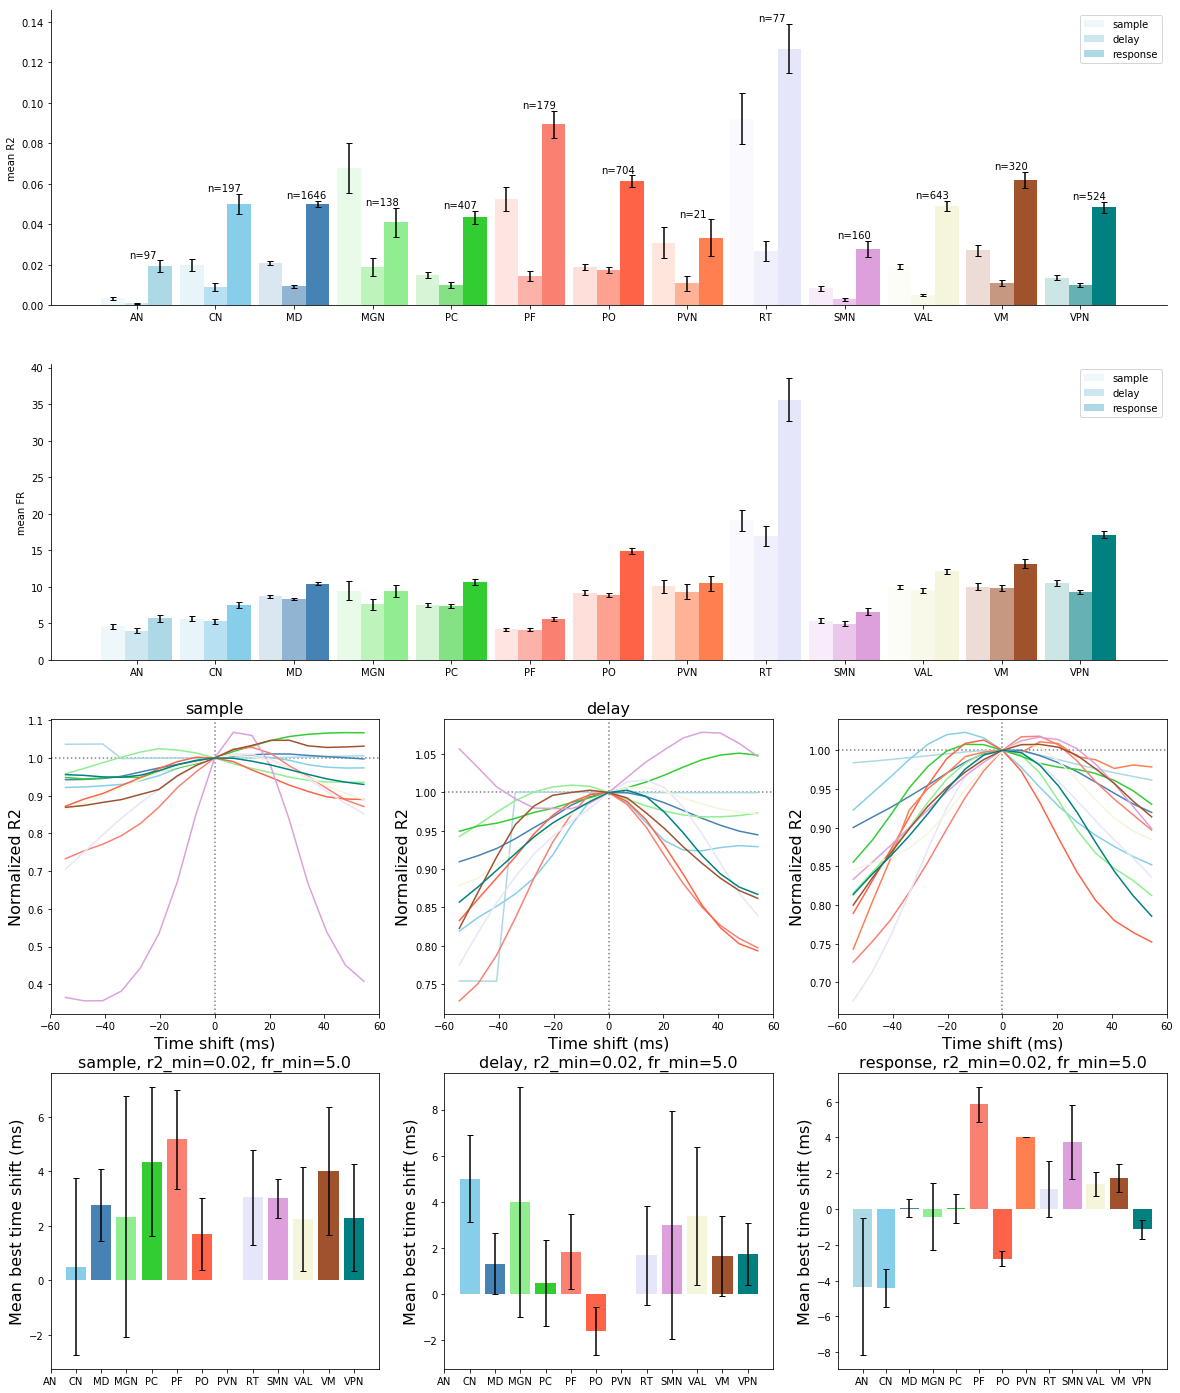

In [39]:
f = plt.figure(figsize=(20,25))
cc = ['grey','blue','green']
cc = [
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",     # A bright red-orange
    "coral",      # A soft, pinkish-orange
    "lavender",   # A soft, light purple
    "plum",       # A dark, rich purple
    "beige",      # A soft, pale sandy color
    "sienna",     # A reddish-brown earth tone
    "teal"        # A medium blue-green color
]

epoch_ls = ['solid','solid','solid']

ax_bar = f.add_subplot(4,1,1)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(r2, inds, thalamus_use_nuclei)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 0.2 + iepoch*0.4, color = cc, 
                capsize = 3, width=0.3, label = epoch)
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, m[i] + sem[i] + 0.1 * max(sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(short_names, rotation = 0)
_ = ax_bar.set_ylabel('mean R2')

ax_bar = f.add_subplot(4,1,2)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m_fr, sem_fr = func.get_mean_and_sem_for_subregions(fr, inds, thalamus_use_nuclei)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m_fr, yerr = sem_fr, alpha = 0.2 + iepoch*0.4, color = cc, 
                capsize = 3, width=0.3, label = epoch)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(short_names, rotation = 0)
_ = ax_bar.set_ylabel('mean FR')

#ax_ts = f.add_subplot(3,1,3)

r2_threshold = .02
fr_threshold = 0.

for iepoch, epoch in enumerate(epochs):
    ax_ts = f.add_subplot(4,3,7 + iepoch)

    r2 = []

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2'%epoch].copy())

    r2= np.array(r2)
    r2[r2<0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[8,:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)



    ax_ts.set_title('%s'%(epoch), fontsize = 16)
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]

        this_inds = np.intersect1d(this_inds, threshold_inds)
        avg_r2 = r2[:,this_inds].mean(axis = 1)

        ax_ts.plot(timeshifts*3.4, avg_r2/avg_r2[8],color = cc[j], ls= epoch_ls[iepoch], label = area + ', ' + epoch)

    a,b = ax_ts.set_xlim()
    ax_ts.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    ax_ts.set_xlim(a,b)

    a,b = ax_ts.set_ylim()
    ax_ts.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    ax_ts.set_ylim(a,b)

    ax_ts.set_xlabel('Time shift (ms)', fontsize = 16)
    ax_ts.set_ylabel('Normalized R2', fontsize = 16)

r2_threshold = .02
fr_threshold = 5.

for iepoch, epoch in enumerate(epochs):
    ax_ts = f.add_subplot(4,3,10 + iepoch)

    r2 = []

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2'%epoch].copy())

    r2= np.array(r2)
    r2[r2<0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[8,:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)


    ax_ts.set_title('%s, r2_min=%.2f, fr_min=%.1f'%(epoch,r2_threshold,fr_threshold), fontsize = 16)

    means = []
    sems = []
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]

        this_inds = np.intersect1d(this_inds, threshold_inds)

        this_area_r2 = r2[:,this_inds]
        best_timeshift = np.argmax(this_area_r2, axis = 0)

        timeshift_array = timeshifts[best_timeshift]

        avg_timeshift = np.mean(timeshift_array)
        std_timeshift = np.std(timeshift_array)
        sem_timeshift = std_timeshift/np.sqrt(len(timeshift_array))
        means.append(avg_timeshift)
        sems.append(sem_timeshift)


    ax_ts.bar(np.arange(len(means)), means, yerr = sems, color = cc, capsize = 3)
    _= ax_ts.set_xticks(np.arange(len(means)))
    _ = ax_ts.set_xticklabels(short_names, rotation = 0)
    ax_ts.set_ylabel('Mean best time shift (ms)', fontsize = 16)  
#ax_ts.legend()

#plt.savefig(figfolder + 'normalized_r2_timeshifts_r2_fr_threshold.png', dpi = 300)

plt.savefig(figfolder + 'thalamus_subregions_with_timeshift_fr_r2_new.png')